## Blosum strategies
* This file compares using the original blosum rows as features vs. doing eigenvalue decomposition and then constructing features

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids

NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*12 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
uniform_pvals = [0.05]*20

encoding_style = 'regular'
lambda_val = 1

In [3]:
# New distribution (not NNK exactly)
aa_list_2 = ["A", "C", "D", "E", "F", "G", "H",  "I",  "K",  "L",  "M",  "N", "P", "Q", "R", "S", "T", "V",  "W", "Y"]
pvals_2 = [0.07668660126327106, 0.035596693992742914, 0.02474465797607849, 0.04041795457599785, 0.02319916677865878, 0.1149711060341352, 0.02187206020696143, 0.021972853111140975, 0.030170675984410696, 0.0904280338664158, 0.030069883080231154, 0.017672355866147026, 0.03937642789947588, 0.03156497782556108, 0.1183812659588765, 0.07880325225104153, 0.043290552345114905, 0.08557317564843435, 0.053369842763069476, 0.02183846257223492]

In [4]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding

In [5]:
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

In [6]:
# Biological features
# kd hydrophobicity scale
hydrophobicity = {'G': -0.4, 'A': 1.8, 'L':3.8, 'M': 1.9, 'F':2.8, 'W':-0.9, 'K':-3.9, 'Q':-3.5, 'E':-3.5, 'S':-0.8, 'P':-1.6, 'V':4.2, 'I':4.5, 'C':2.5, 'Y':-1.3, 'H':-3.2, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'T':-0.7}
# Ranked
polarity = {'A': 0.45, 'R': 0.75, 'N': 0.8, 'D': 0.95, 'C':0.35, 'Q': 0.85, 'E': 0.90, 'G': 0.55, 'H': 0.5, 'I': 0.05, 'L': 0.15, 'K': 1, 'M': 0.25, 'F': 0.1, 'P': 0.65, 'S': 0.7, 'T': 0.6, 'W': 0.3, 'Y': 0.4, 'V': 0.2}
# Van der waal's volume
volume = {'A': 67, 'R': 148, 'N': 96, 'D': 91, 'C':86, 'Q': 114, 'E': 109, 'G': 48, 'H': 118, 'I': 124, 'L': 124, 'K': 135, 'M': 124, 'F': 135, 'P': 90, 'S': 73, 'T': 93, 'W':163, 'Y':141, 'V': 105}

# TODO: branched, hydrophilic, hydrophobic, shape
charge = {'A': 2, 'R': 3, 'N': 2, 'D': 1, 'C': 2, 'E':1, 'Q':2, 'G':2, 'H': 3, 'I':2, 'L': 2, 'K': 3, 'M':2, 'F':2, 'P':2, 'S':2, 'T': 2, 'W':2, 'Y': 2, 'V':2 }

# Normalize all of the biological features:
# Charge
for k,v in charge.items():
    if v == 1:
        charge[k] = 0
    elif v == 2:
        charge[k] = 0.5
    else:
        charge[k] = 1.0

# Volume
for k,v in volume.items():
    volume[k] = v/163.0

#Polarity
min_v = -4.5
max_v = 4.5
for k,v in hydrophobicity.items():
    hydrophobicity[k] = (v - min_v)/(max_v - min_v)  

## Dataset

In [7]:
class BinaryDataset(Dataset):
    def __init__(self, filepath, distribution='NNK', negfilepath=None, use_negative_replicate=False):
        def construct_binary_dataset(filepath, distribution='NNK', negfilepath=None, use_negative_replicate=False):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    if not use_negative_replicate:
                        ds.append((get_x(), get_y(), 0))
            if use_negative_replicate:
                with open(negfilepath, 'r') as f:
                    neg_data = json.load(f)
                for aptamer in neg_data:
                    peptides = neg_data[aptamer]
                    for peptide in peptides:
                        ds.append((aptamer, peptide, 0))
            
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath, distribution, negfilepath, use_negative_replicate)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [8]:
class EvalDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [9]:
class AUCDataset(Dataset):
    def __init__(self, filepath, distribution='NNK', negfilepath=None, use_negative_replicate=False):
        def construct_dataset(filepath, distribution='NNK', negfilepath=None, use_negative_replicate=False):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            bio_ds = []
            gen_ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    bio_ds.append((aptamer, peptide, 1))
                    if not use_negative_replicate:
                        gen_ds.append((get_x(), get_y(distribution), 0))
            if use_negative_replicate:
                with open(negfilepath, 'r') as f:
                    neg_data = json.load(f)
                for aptamer in neg_data:
                    peptides = neg_data[aptamer]
                    for peptide in peptides:
                        gen_ds.append((aptamer, peptide, 0))
            bio_ds = list(set(bio_ds)) #removed duplicates, random order
            gen_ds = list(set(gen_ds)) #removed duplicates, random order
            print("Length of Positive dataset: ", len(bio_ds))
            print("length of negative dataset: ", len(gen_ds))
            return bio_ds, gen_ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x
        
         # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution='NNK'):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.bio_ds, self.gen_ds = construct_dataset(filepath, distribution, negfilepath, use_negative_replicate)

    def __len__(self):
        return min(len(self.bio_ds), len(self.gen_ds))

    def __getitem__(self,idx):
        return(self.bio_ds[idx], self.gen_ds[idx])

In [10]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [11]:
binary_ds=BinaryDataset(filepath="../data/experimental_replicate_1.json", distribution='NNK', negfilepath='../data/neg_datasets/neg1_all_pairs_noArgi_noHis.json', use_negative_replicate=True)
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]
auc_ds = AUCDataset(filepath="../data/experimental_replicate_1.json", distribution='NNK', negfilepath='../data/neg_datasets/neg1_all_pairs_noArgi_noHis.json', use_negative_replicate=True)

Length of Positive dataset:  245944
length of negative dataset:  220610


In [12]:
auc_ds_1 = AUCDataset(filepath='../data/experimental_replicate_2.json', distribution='NNK', negfilepath='../data/neg_datasets/neg2_all_pairs_noArgi_noHis.json', use_negative_replicate=True)
auc_ds_2 = AUCDataset(filepath='../data/experimental_replicate_3.json', distribution='NNK', negfilepath='../data/neg_datasets/neg3_all_pairs_noArgi_noHis.json', use_negative_replicate=True)
auc_ds_3 = AUCDataset(filepath='../data/experimental_replicate_4.json', distribution='NNK', negfilepath='../data/neg_datasets/neg4_all_pairs_noArgi_noHis.json', use_negative_replicate=True)

Length of Positive dataset:  234511
length of negative dataset:  340347
Length of Positive dataset:  183393
length of negative dataset:  293008
Length of Positive dataset:  109158
length of negative dataset:  265810


In [13]:
#half_ds = HalfDataset(filepath="../data/higher_quality_data.json")
#eval_ds = EvalDataset(filepath="../data/experimental_replicate_data.json")

## NN Model

In [14]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [15]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumConvNet(nn.Module):
    def __init__(self):
        super(BlosumConvNet, self).__init__()
        self.name = "BlosumConvNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 100, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(100, 200, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(200, 300, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 100, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(200, 300, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(300, 350, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(1400, 700 )
        self.fc2 = nn.Linear(700, 250)
        self.fc3 = nn.Linear(250, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [16]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [17]:
class LinearBaseline(nn.Module):
    def __init__(self):
        super(LinearBaseline, self).__init__()
        self.name = "LinearBaseline"
        self.single_alphabet = False
        
        self.fc_1 = nn.Linear(320, 1)
    
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [24]:
class ConvBaseline(nn.Module):
    def __init__(self):
        super(ConvBaseline, self).__init__()
        self.name = "ConvBaseline"
        self.single_alphabet = True
        
        self.cnn_1 = nn.Conv1d(24, 100, 3)
        self.fc_1 = nn.Linear(4600, 1)
        
    
    def forward(self, pair):
        x = self.cnn_1(pair)
        x = x.view(-1, 1).T
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [19]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [20]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to directly translated sequence
def translate(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        
        encoding = np.zeros(len(apt) + len(pep))
        
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            idx = na_list.index(char)
            encoding[i] = idx
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            idx = aa_list.index(char)
            encoding[i+len(apt)] = idx
        return encoding     
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        
        encoding = np.zeros(len(sequence))
        for i in range(len(sequence)):
            char = sequence[i]
            idx = letters.index(char)
            encoding[i] = idx
        return encoding

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[1], pair.shape[0]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') 
        pep = one_hot(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 1, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [21]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [22]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None,
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    # Number of times that val_score < train_score
    auc_tracker = 0
    auc_count = 0
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            lam = 1
            # The original label is non binding
            if label == 0.0:
                train_gen_scores.append(train_score.item())
                # Score is non binding
                if train_score.item() < 0.5:
                    train_stats[1] += 1
                    train_correct += 1
                # Score is binding
                else:
                    lam = lambda_val
                    train_stats[2] += 1
            # The original label is binding
            elif label == 1.0:
                train_scores.append(train_score.item())
                # The score is binding
                if train_score.item() >= 0.5:
                    train_correct += 1
                    train_stats[0] += 1
                # The score is nonbinding
                else:
                    train_stats[3] += 1
                    lam = lambda_val
                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss

            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            
            
            # Calculate AUC
            auc_count += 1
            idx = int(random.random()*len(auc_ds))
            bio_sample, gen_sample = auc_ds[idx]
            if single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
                bio_score = model(p)
                p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
                gen_score = model(p)
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
                bio_score = model(a, p)
                a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
                gen_score = model(a, p)
            if bio_score > gen_score:
                auc_tracker += 1
            
            lam = 1
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
                if val_score.item() < 0.5:
                    val_stats[1] += 1
                    val_correct += 1
                else:
                    lam = lambda_val
                    val_stats[2] += 1
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
                if val_score.item() >= 0.5:
                    val_stats[0] += 1
                    val_correct += 1
                else:
                    val_stats[3] += 1
                    lam = lambda_val

            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss

            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))
                
            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
                print("Training CDF at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation CDF epoch %d: {}".format(val_auc) % full_epoch)
                print("AUC epoch %d: {}".format(auc_tracker/float(auc_count)) % full_epoch)
                print("Train: Sensitivity: " + str(train_stats[0]/(train_stats[0] + train_stats[3])) + " Specificity: " + str(train_stats[1]/(train_stats[2] + train_stats[1])))
                print("Val: Sensitivity: " + str(val_stats[0]/(val_stats[0] + val_stats[3])) + " Specificity: " + str(val_stats[1]/(val_stats[2] + val_stats[1])))

        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 24/373243 [00:00<26:43, 232.76it/s]

Using lambda val= 1
Using encoding_style= regular
Starting epoch: 0  with learning rate:  [0.01]


 13%|█▎        | 49984/373243 [03:26<22:44, 236.86it/s]

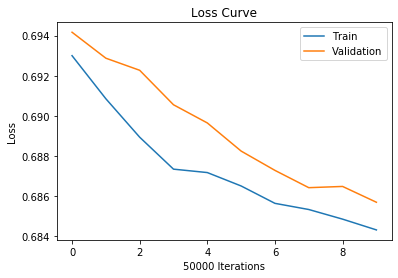

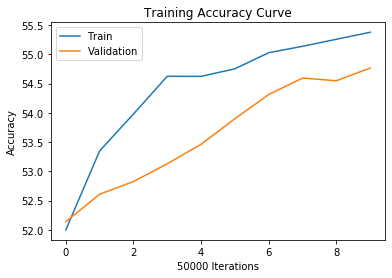

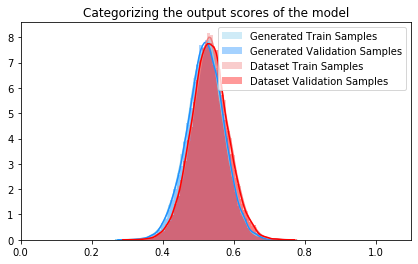

 13%|█▎        | 49984/373243 [03:40<22:44, 236.86it/s]

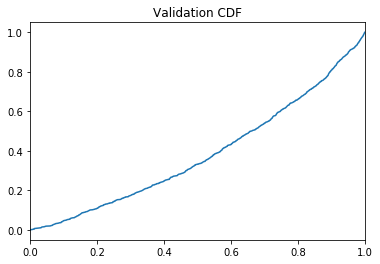

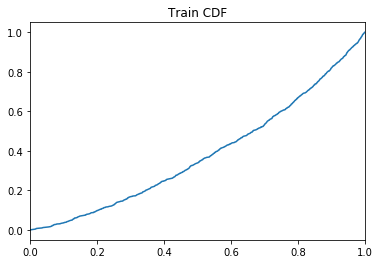

 13%|█▎        | 50027/373243 [04:21<64:52:31,  1.38it/s]

Training Accuracy at epoch 0: 55.378
Validation Accuracy epoch 0: 54.766
Training CDF at epoch 0: 0.3823956363636364
Validation CDF epoch 0: 0.38382936363636366
AUC epoch 0: 0.57048
Train: Sensitivity: 0.7399203489474683 Specificity: 0.34613920033848106
Val: Sensitivity: 0.7348248879434779 Specificity: 0.3395285967728309


 27%|██▋       | 99987/373243 [07:53<20:21, 223.64it/s]  

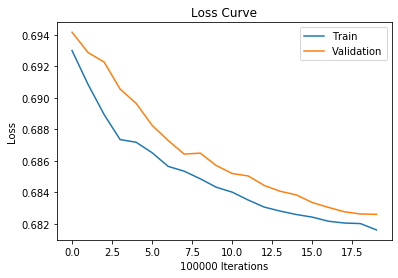

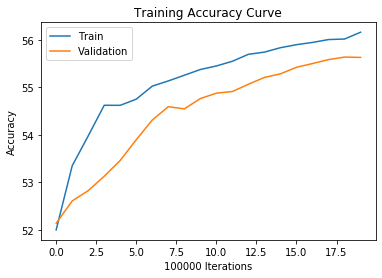

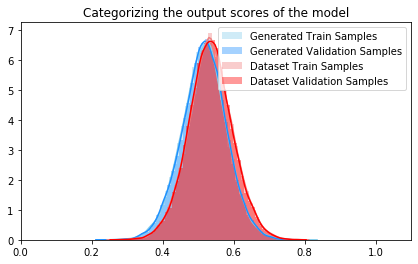

 27%|██▋       | 99987/373243 [08:10<20:21, 223.64it/s]

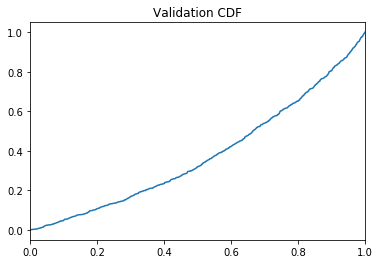

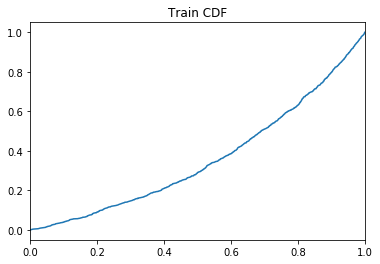

 27%|██▋       | 100041/373243 [08:53<52:04:36,  1.46it/s] 

Training Accuracy at epoch 0: 56.163
Validation Accuracy epoch 0: 55.633
Training CDF at epoch 0: 0.3596941818181818
Validation CDF epoch 0: 0.37895463636363635
AUC epoch 0: 0.5821
Train: Sensitivity: 0.7181214421252372 Specificity: 0.38727272727272727
Val: Sensitivity: 0.7149913229208383 Specificity: 0.38140991947522235


 40%|████      | 149996/373243 [12:27<15:23, 241.78it/s]  

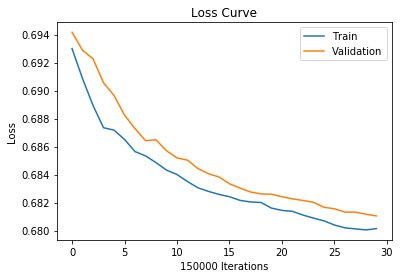

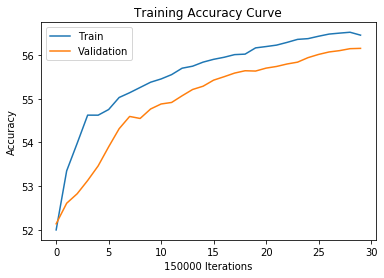

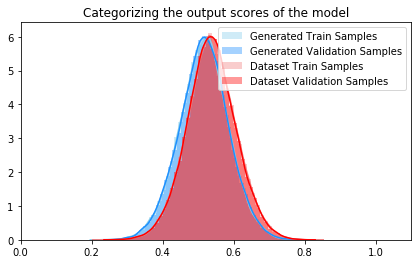

 40%|████      | 149996/373243 [12:40<15:23, 241.78it/s]

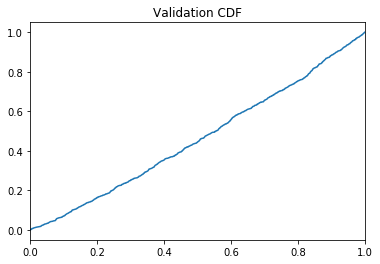

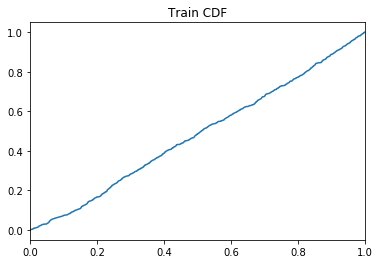

 40%|████      | 150016/373243 [13:28<199:07:06,  3.21s/it]

Training Accuracy at epoch 0: 56.454
Validation Accuracy epoch 0: 56.152
Training CDF at epoch 0: 0.48118399999999995
Validation CDF epoch 0: 0.4627128181818182
AUC epoch 0: 0.5875266666666666
Train: Sensitivity: 0.7118226600985221 Specificity: 0.3999152901313003
Val: Sensitivity: 0.7095107522786707 Specificity: 0.39784629208435124


 54%|█████▎    | 199998/373243 [17:02<11:24, 253.25it/s]   

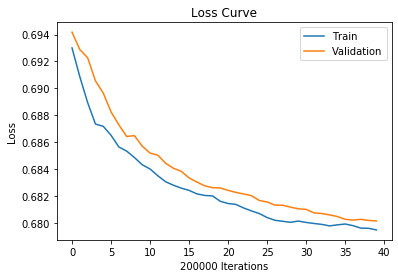

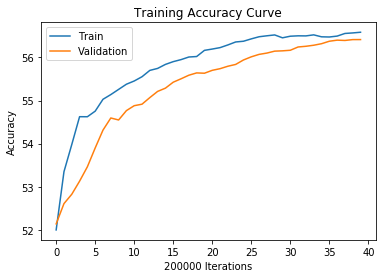

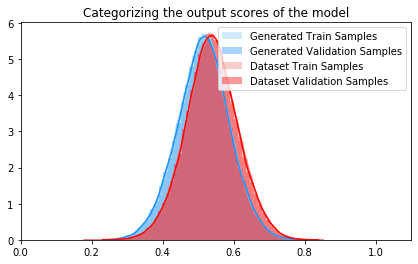

 54%|█████▎    | 199998/373243 [17:21<11:24, 253.25it/s]

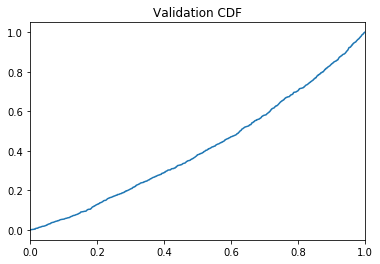

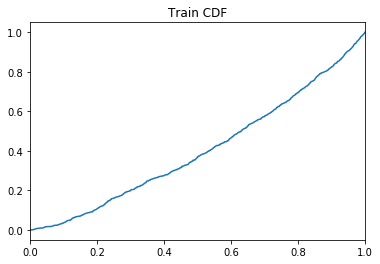

 54%|█████▎    | 200027/373243 [18:03<305:02:01,  6.34s/it]

Training Accuracy at epoch 0: 56.583
Validation Accuracy epoch 0: 56.413
Training CDF at epoch 0: 0.4044297272727273
Validation CDF epoch 0: 0.41451581818181815
AUC epoch 0: 0.59011
Train: Sensitivity: 0.704659532152666 Specificity: 0.41056032199978815
Val: Sensitivity: 0.7044815390335282 Specificity: 0.4093246269833759


 67%|██████▋   | 249999/373243 [21:32<07:04, 290.31it/s]   

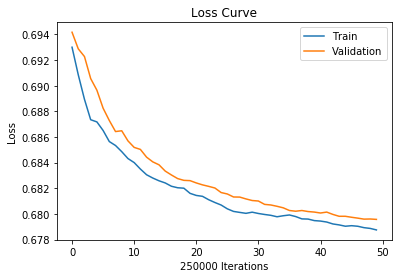

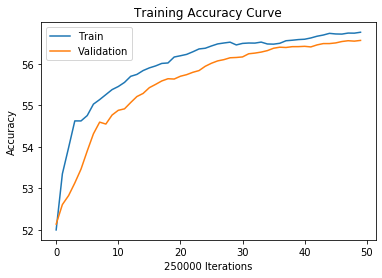

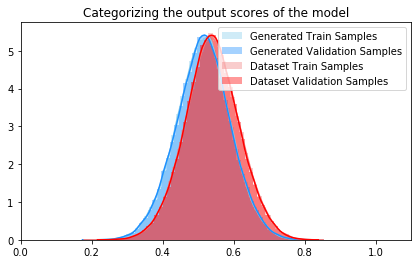

 67%|██████▋   | 249999/373243 [21:51<07:04, 290.31it/s]

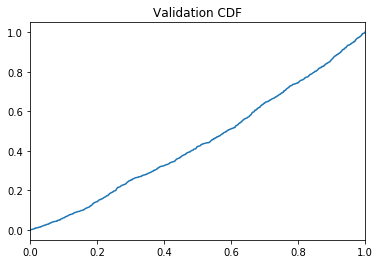

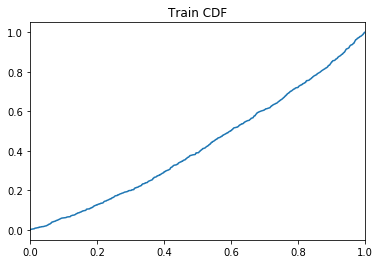

 67%|██████▋   | 250037/373243 [22:32<428:46:58, 12.53s/it]

Training Accuracy at epoch 0: 56.7596
Validation Accuracy epoch 0: 56.5628
Training CDF at epoch 0: 0.42419890909090907
Validation CDF epoch 0: 0.4445314545454545
AUC epoch 0: 0.593184
Train: Sensitivity: 0.7005030760372155 Specificity: 0.4189489204487679
Val: Sensitivity: 0.7003871774156669 Specificity: 0.41678872670336886


 80%|████████  | 299981/373243 [25:21<05:21, 228.21it/s]   

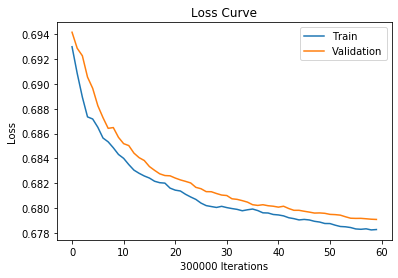

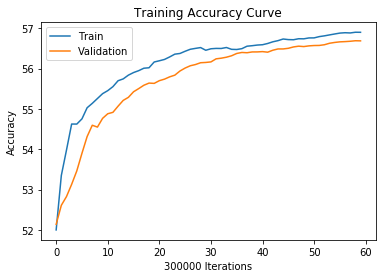

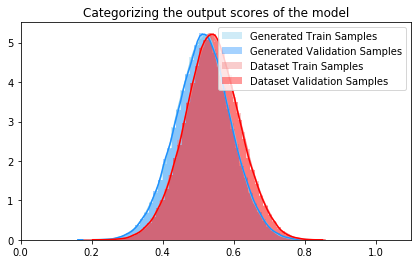

 80%|████████  | 299981/373243 [25:32<05:21, 228.21it/s]

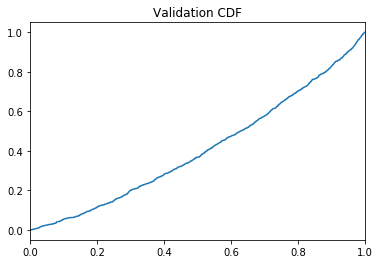

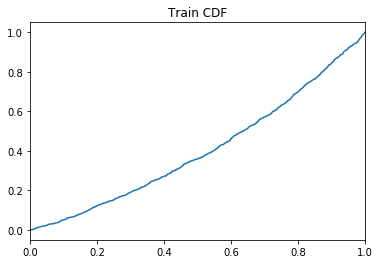

 80%|████████  | 300029/373243 [26:22<13:45:12,  1.48it/s]

Training Accuracy at epoch 0: 56.89933333333333
Validation Accuracy epoch 0: 56.687
Training CDF at epoch 0: 0.40514409090909087
Validation CDF epoch 0: 0.4072243636363636
AUC epoch 0: 0.5952833333333334
Train: Sensitivity: 0.6971216705301255 Specificity: 0.42581469377960035
Val: Sensitivity: 0.6964328815152632 Specificity: 0.4237875450681107


 94%|█████████▍| 349973/373243 [29:55<01:43, 225.02it/s]  

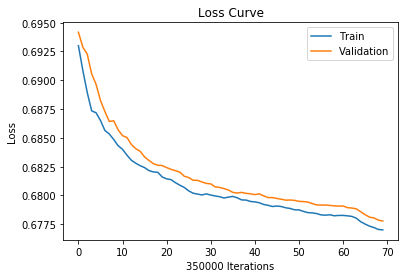

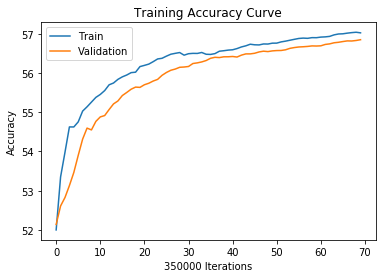

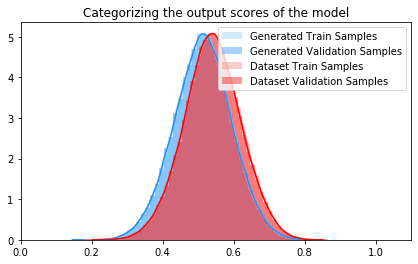

 94%|█████████▍| 349973/373243 [30:12<01:43, 225.02it/s]

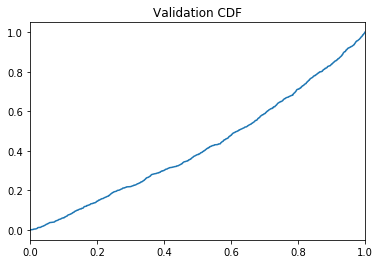

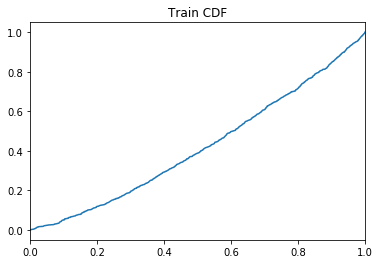

 94%|█████████▍| 350016/373243 [30:56<3:05:03,  2.09it/s]

Training Accuracy at epoch 0: 57.02314285714286
Validation Accuracy epoch 0: 56.848
Training CDF at epoch 0: 0.42034936363636366
Validation CDF epoch 0: 0.4219372727272727
AUC epoch 0: 0.5972485714285715
Train: Sensitivity: 0.6946148639501828 Specificity: 0.43128988356267955
Val: Sensitivity: 0.693744555749129 Specificity: 0.43014069264069266


  0%|          | 24/373243 [00:00<26:46, 232.33it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 1  with learning rate:  [0.01]


  7%|▋         | 26748/373243 [01:54<23:43, 243.37it/s]

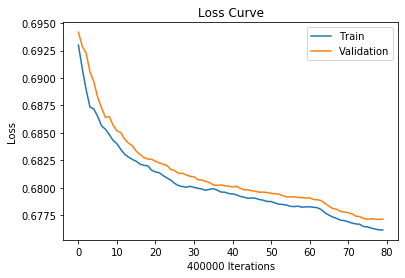

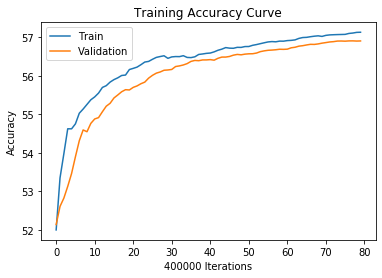

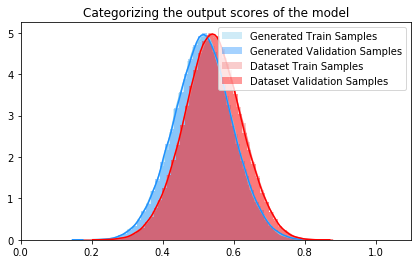

  7%|▋         | 26748/373243 [02:10<23:43, 243.37it/s]

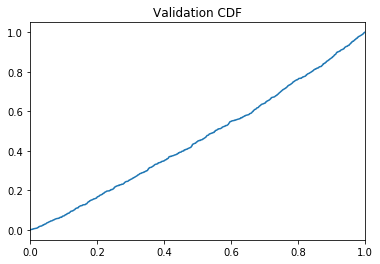

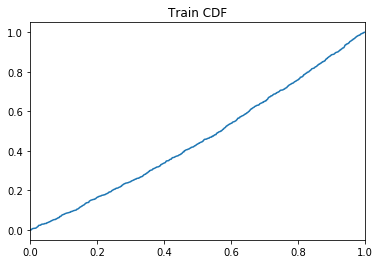

  7%|▋         | 26784/373243 [02:57<139:43:30,  1.45s/it]

Training Accuracy at epoch 1: 57.13125
Validation Accuracy epoch 1: 56.90525
Training CDF at epoch 1: 0.4588120909090909
Validation CDF epoch 1: 0.460018
AUC epoch 1: 0.5979625
Train: Sensitivity: 0.6932961237959414 Specificity: 0.4350518410314222
Val: Sensitivity: 0.6917028612793843 Specificity: 0.43352418641855767


 21%|██        | 76735/373243 [06:30<20:23, 242.40it/s]   

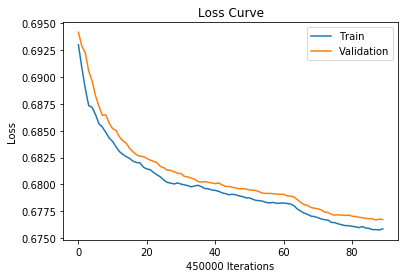

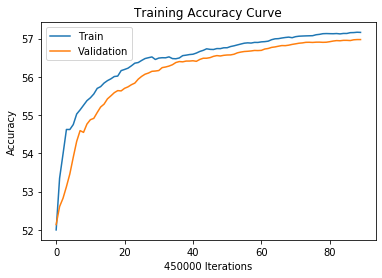

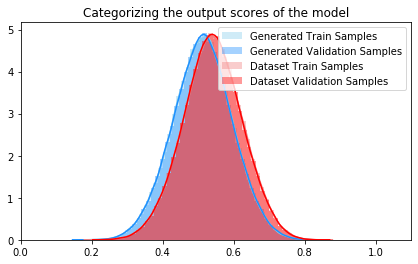

 21%|██        | 76735/373243 [06:40<20:23, 242.40it/s]

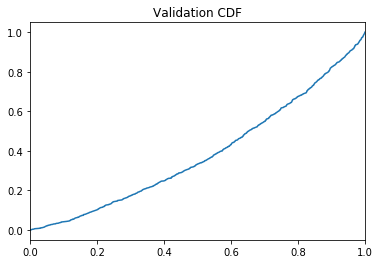

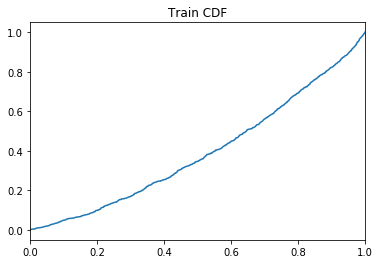

 21%|██        | 76783/373243 [07:31<47:59:07,  1.72it/s]

Training Accuracy at epoch 1: 57.162
Validation Accuracy epoch 1: 56.974444444444444
Training CDF at epoch 1: 0.3932691818181818
Validation CDF epoch 1: 0.3854660909090909
AUC epoch 1: 0.5989288888888888
Train: Sensitivity: 0.690976493386132 Specificity: 0.4383642178534475
Val: Sensitivity: 0.6897925993062644 Specificity: 0.43722152351475313


 34%|███▍      | 126753/373243 [11:04<17:34, 233.85it/s] 

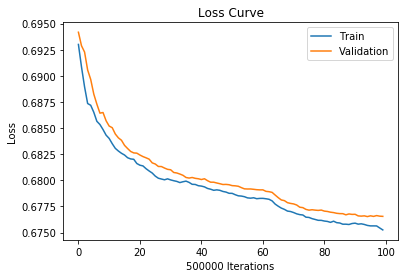

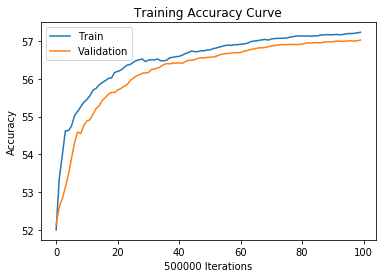

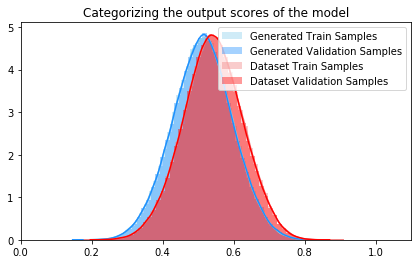

 34%|███▍      | 126753/373243 [11:21<17:34, 233.85it/s]

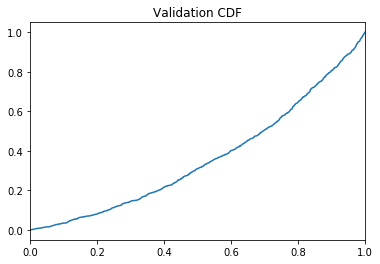

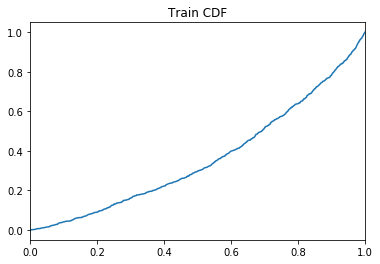

 34%|███▍      | 126786/373243 [12:07<226:42:30,  3.31s/it]

Training Accuracy at epoch 1: 57.2294
Validation Accuracy epoch 1: 57.0216
Training CDF at epoch 1: 0.36216363636363635
Validation CDF epoch 1: 0.3617925454545454
AUC epoch 1: 0.600004
Train: Sensitivity: 0.6912247202079214 Specificity: 0.43931049675074346
Val: Sensitivity: 0.6898683784453037 Specificity: 0.43797393739079177


 47%|████▋     | 176738/373243 [15:41<14:12, 230.51it/s]   

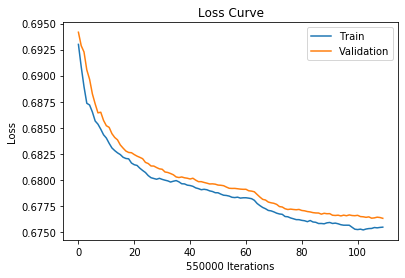

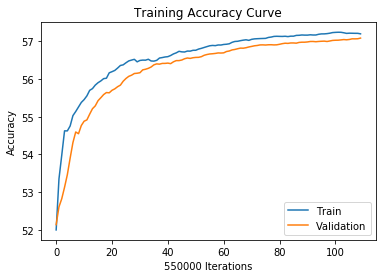

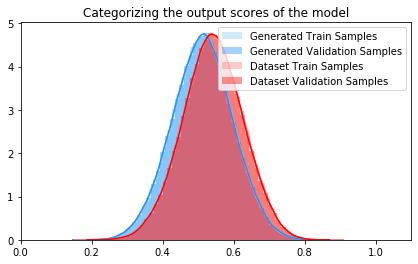

 47%|████▋     | 176738/373243 [15:51<14:12, 230.51it/s]

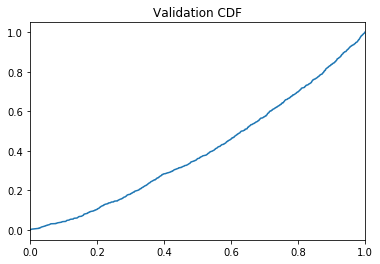

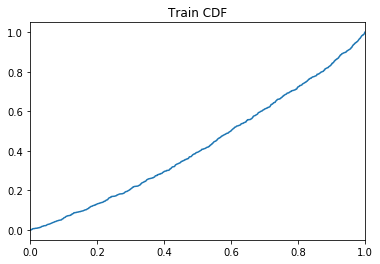

 47%|████▋     | 176773/373243 [16:44<38:03:01,  1.43it/s]

Training Accuracy at epoch 1: 57.196
Validation Accuracy epoch 1: 57.083090909090906
Training CDF at epoch 1: 0.42461263636363633
Validation CDF epoch 1: 0.4030392727272727
AUC epoch 1: 0.6002127272727272
Train: Sensitivity: 0.6891044416112471 Specificity: 0.4410985796220024
Val: Sensitivity: 0.6883713034561126 Specificity: 0.4410144173375371


 61%|██████    | 226753/373243 [20:17<09:40, 252.37it/s]  

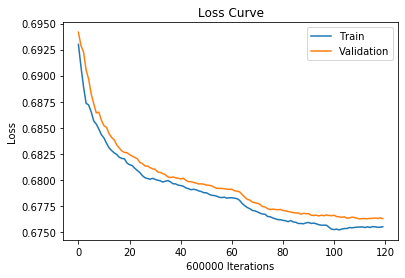

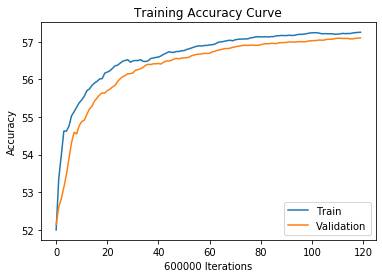

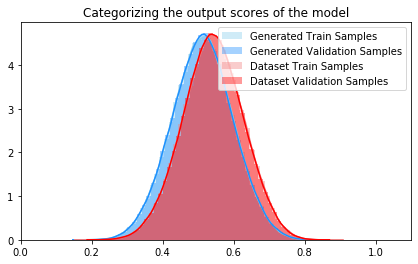

 61%|██████    | 226753/373243 [20:31<09:40, 252.37it/s]

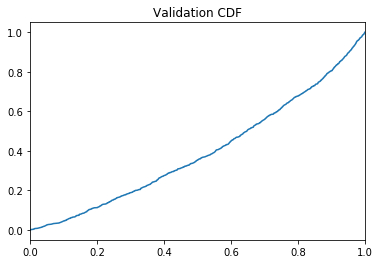

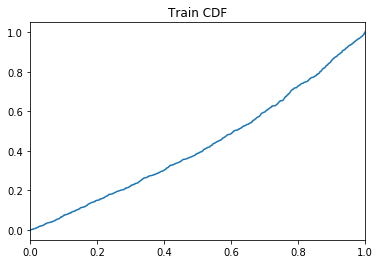

 61%|██████    | 226784/373243 [21:21<135:31:08,  3.33s/it]

Training Accuracy at epoch 1: 57.25033333333333
Validation Accuracy epoch 1: 57.099333333333334
Training CDF at epoch 1: 0.4285339090909091
Validation CDF epoch 1: 0.3950880909090909
AUC epoch 1: 0.6002616666666667
Train: Sensitivity: 0.6887324788672798 Specificity: 0.44258076813113506
Val: Sensitivity: 0.6879470450973856 Specificity: 0.441741662719506


 74%|███████▍  | 276737/373243 [24:55<06:38, 242.17it/s]   

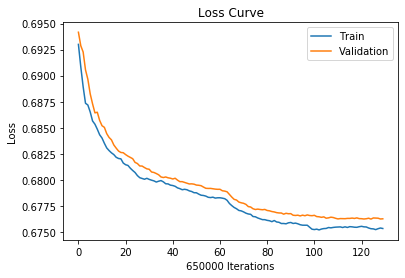

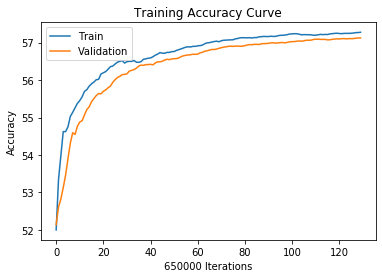

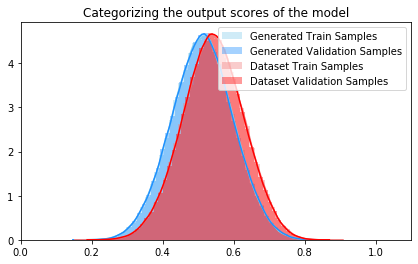

 74%|███████▍  | 276737/373243 [25:12<06:38, 242.17it/s]

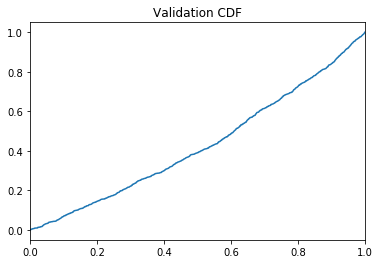

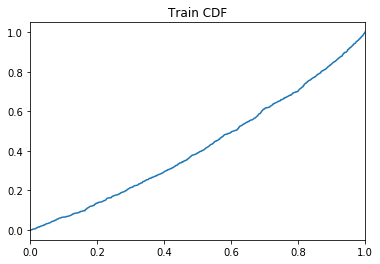

 74%|███████▍  | 276783/373243 [25:59<18:03:00,  1.48it/s]

Training Accuracy at epoch 1: 57.27661538461538
Validation Accuracy epoch 1: 57.124923076923075
Training CDF at epoch 1: 0.422816
Validation CDF epoch 1: 0.42935327272727275
AUC epoch 1: 0.6007123076923077
Train: Sensitivity: 0.6879175264943513 Specificity: 0.4440386044026223
Val: Sensitivity: 0.6872546921762377 Specificity: 0.4431093713068283


 88%|████████▊ | 326734/373243 [29:09<02:42, 287.00it/s]  

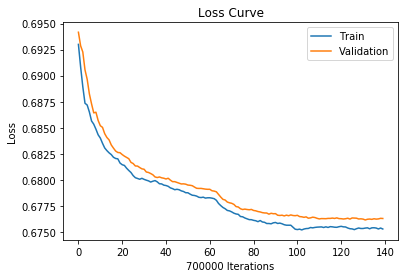

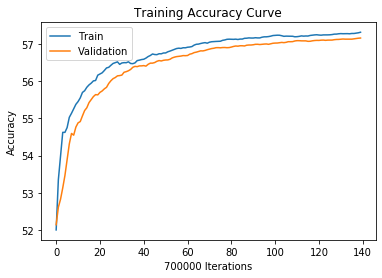

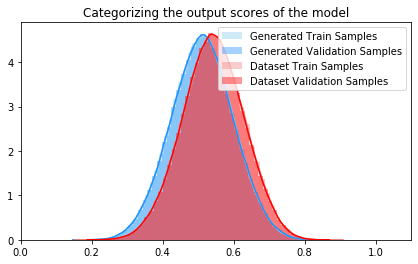

 88%|████████▊ | 326734/373243 [29:22<02:42, 287.00it/s]

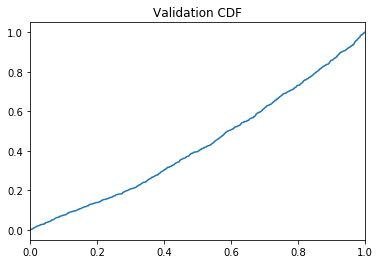

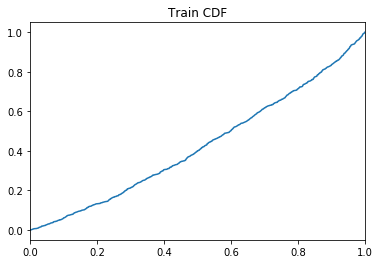

 88%|████████▊ | 326789/373243 [30:13<7:30:27,  1.72it/s] 

Training Accuracy at epoch 1: 57.31785714285714
Validation Accuracy epoch 1: 57.162
Training CDF at epoch 1: 0.4261723636363637
Validation CDF epoch 1: 0.43216836363636363
AUC epoch 1: 0.6011571428571428
Train: Sensitivity: 0.6867019721238506 Specificity: 0.4463695970385783
Val: Sensitivity: 0.6856647515261701 Specificity: 0.44562612567916604


  0%|          | 21/373243 [00:00<29:59, 207.38it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 2  with learning rate:  [0.01]


  1%|          | 3496/373243 [00:15<25:04, 245.74it/s]

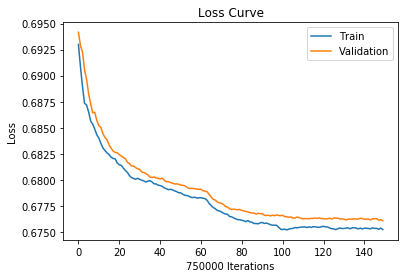

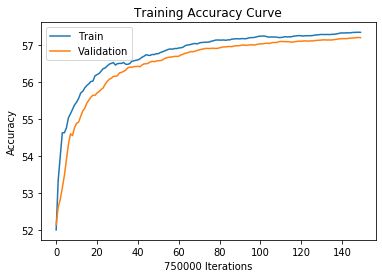

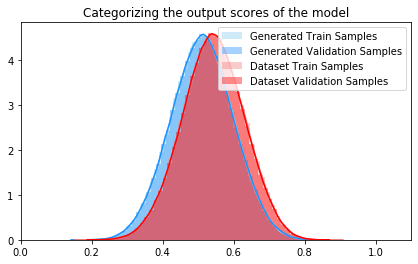

  1%|          | 3496/373243 [00:30<25:04, 245.74it/s]

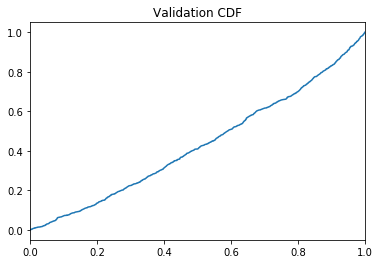

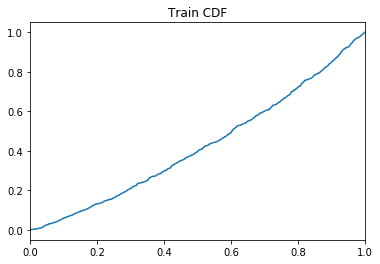

  1%|          | 3530/373243 [01:19<77:48:37,  1.32it/s] 

Training Accuracy at epoch 2: 57.3372
Validation Accuracy epoch 2: 57.194
Training CDF at epoch 2: 0.42523209090909087
Validation CDF epoch 2: 0.43055454545454547
AUC epoch 2: 0.6015053333333333
Train: Sensitivity: 0.6862326951696814 Specificity: 0.44727563242986884
Val: Sensitivity: 0.6852468179162114 Specificity: 0.44679985409242684


 14%|█▍        | 53493/373243 [04:55<22:59, 231.73it/s] 

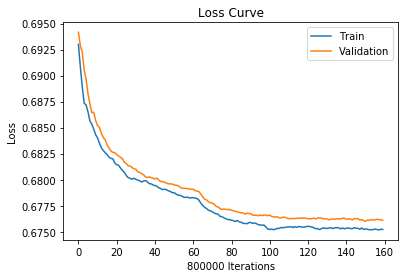

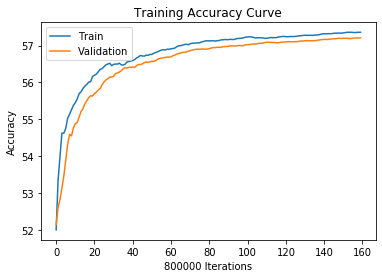

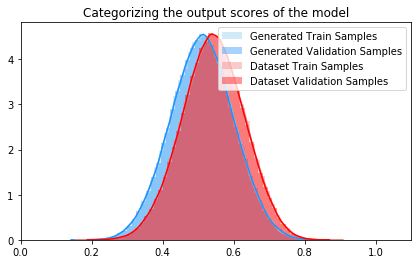

 14%|█▍        | 53493/373243 [05:10<22:59, 231.73it/s]

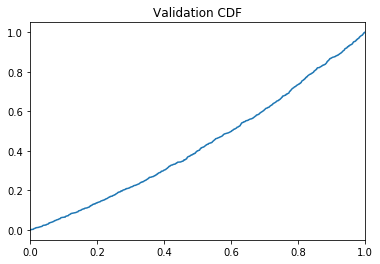

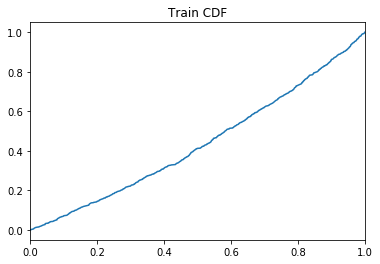

 14%|█▍        | 53541/373243 [06:00<57:50:56,  1.54it/s]

Training Accuracy at epoch 2: 57.36225
Validation Accuracy epoch 2: 57.213125
Training CDF at epoch 2: 0.4373814545454546
Validation CDF epoch 2: 0.43204
AUC epoch 2: 0.60177625
Train: Sensitivity: 0.685483966485608 Specificity: 0.4486480192032351
Val: Sensitivity: 0.6843131698698182 Specificity: 0.44817115687713954


 28%|██▊       | 103498/373243 [09:35<19:48, 227.03it/s] 

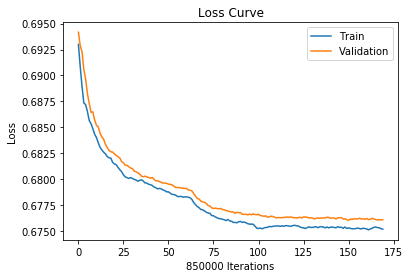

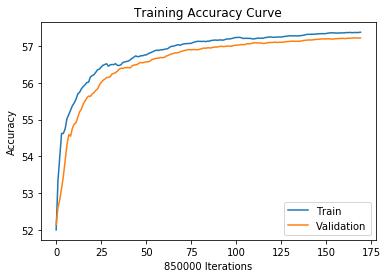

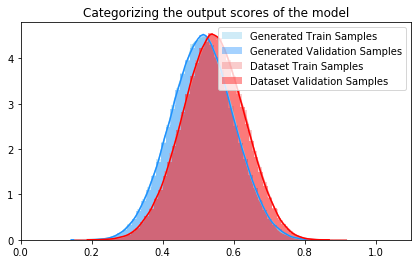

 28%|██▊       | 103498/373243 [09:50<19:48, 227.03it/s]

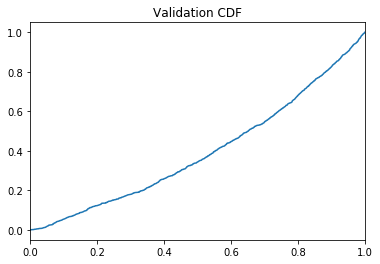

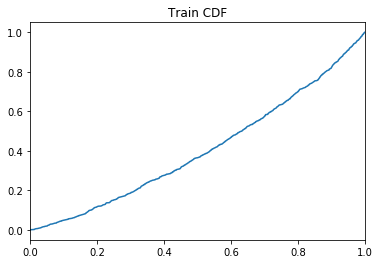

 28%|██▊       | 103541/373243 [10:40<64:07:07,  1.17it/s]

Training Accuracy at epoch 2: 57.377764705882356
Validation Accuracy epoch 2: 57.22176470588235
Training CDF at epoch 2: 0.40422972727272727
Validation CDF epoch 2: 0.39452790909090907
AUC epoch 2: 0.60196
Train: Sensitivity: 0.684894184376923 Specificity: 0.44964431957437906
Val: Sensitivity: 0.6838525565870028 Specificity: 0.4489288640983172


 41%|████      | 153510/373243 [14:16<15:46, 232.21it/s]  

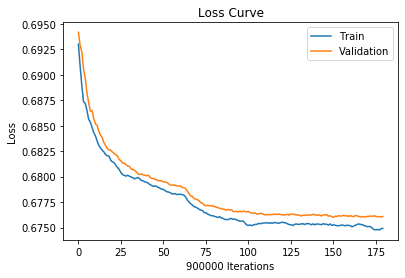

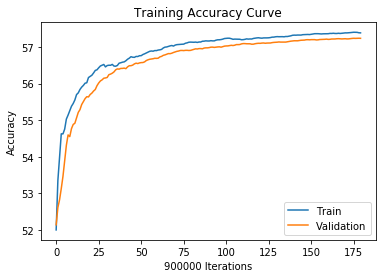

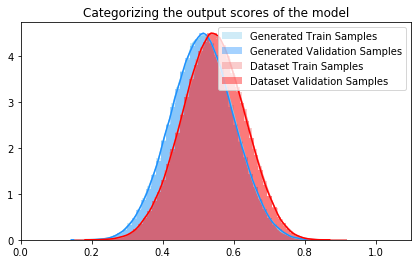

 41%|████      | 153510/373243 [14:31<15:46, 232.21it/s]

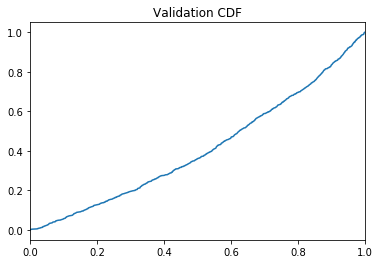

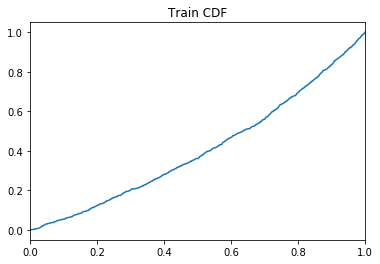

 41%|████      | 153541/373243 [15:23<212:20:01,  3.48s/it]

Training Accuracy at epoch 2: 57.38366666666667
Validation Accuracy epoch 2: 57.23511111111111
Training CDF at epoch 2: 0.4074766363636363
Validation CDF epoch 2: 0.4095000909090909
AUC epoch 2: 0.6020955555555556
Train: Sensitivity: 0.6847076161903258 Specificity: 0.44993588612434565
Val: Sensitivity: 0.683536773827518 Specificity: 0.44953066464620955


 55%|█████▍    | 203486/373243 [18:59<12:27, 226.98it/s]   

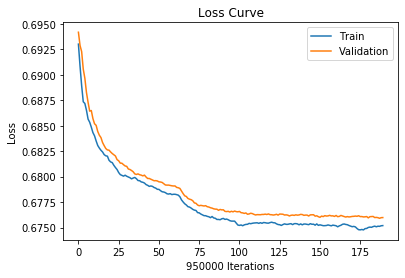

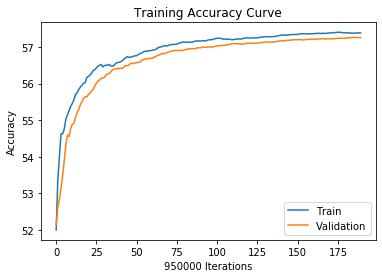

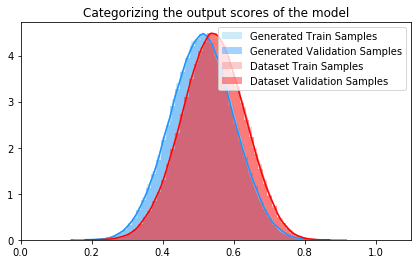

 55%|█████▍    | 203486/373243 [19:11<12:27, 226.98it/s]

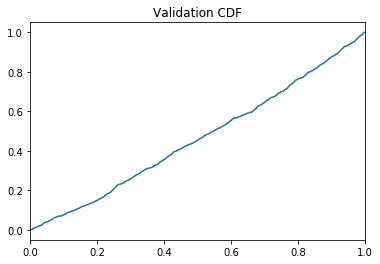

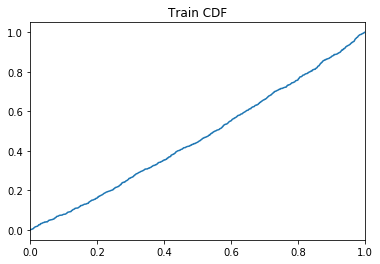

 55%|█████▍    | 203530/373243 [20:03<23:00:40,  2.05it/s]

Training Accuracy at epoch 2: 57.380105263157894
Validation Accuracy epoch 2: 57.25357894736842
Training CDF at epoch 2: 0.4658208181818182
Validation CDF epoch 2: 0.46260754545454547
AUC epoch 2: 0.6024589473684211
Train: Sensitivity: 0.6841574046739486 Specificity: 0.45049123182397677
Val: Sensitivity: 0.6831946308186356 Specificity: 0.45033237272705123


 68%|██████▊   | 253488/373243 [23:39<08:37, 231.32it/s]  

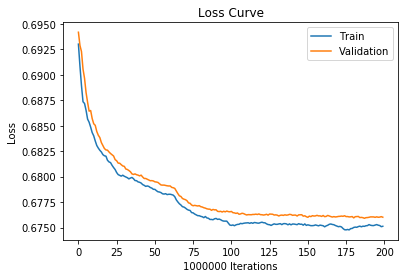

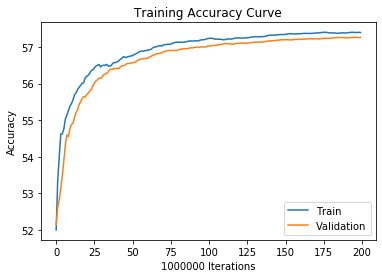

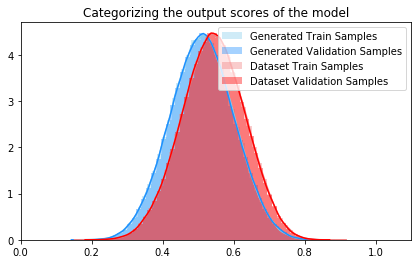

 68%|██████▊   | 253488/373243 [23:51<08:37, 231.32it/s]

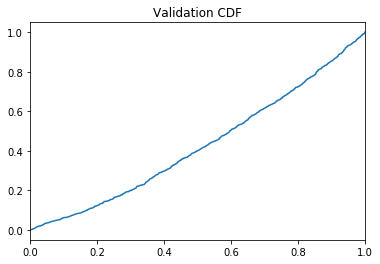

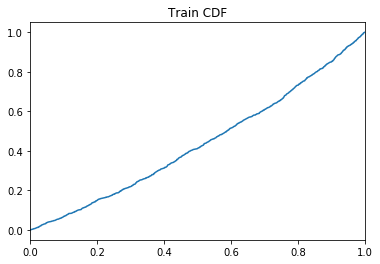

 68%|██████▊   | 253541/373243 [24:46<18:02:01,  1.84it/s]

Training Accuracy at epoch 2: 57.3951
Validation Accuracy epoch 2: 57.2595
Training CDF at epoch 2: 0.4371608181818182
Validation CDF epoch 2: 0.42749236363636367
AUC epoch 2: 0.602584
Train: Sensitivity: 0.6839352810657895 Specificity: 0.4510366528954496
Val: Sensitivity: 0.6827993559880724 Specificity: 0.45087075016047057


 81%|████████▏ | 303493/373243 [28:22<04:40, 248.88it/s]  

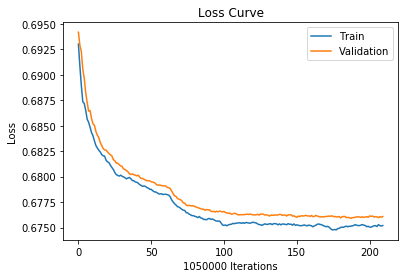

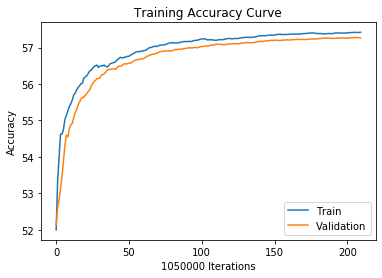

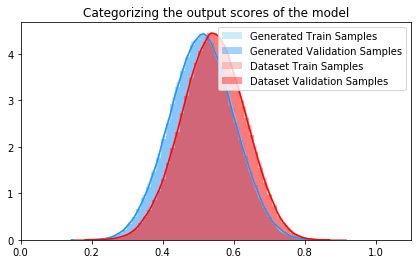

 81%|████████▏ | 303493/373243 [28:42<04:40, 248.88it/s]

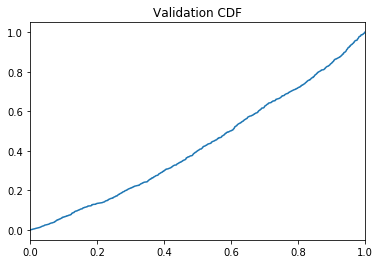

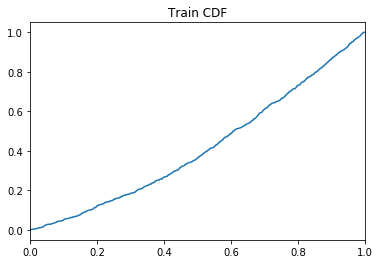

 81%|████████▏ | 303542/373243 [29:30<13:12:03,  1.47it/s]

Training Accuracy at epoch 2: 57.41809523809524
Validation Accuracy epoch 2: 57.26790476190476
Training CDF at epoch 2: 0.4165212727272727
Validation CDF epoch 2: 0.4287235454545455
AUC epoch 2: 0.6026790476190477
Train: Sensitivity: 0.6835293629293806 Specificity: 0.4520070898960915
Val: Sensitivity: 0.6822334767468657 Specificity: 0.451667926071279


 95%|█████████▍| 353505/373243 [33:06<01:27, 225.63it/s]  

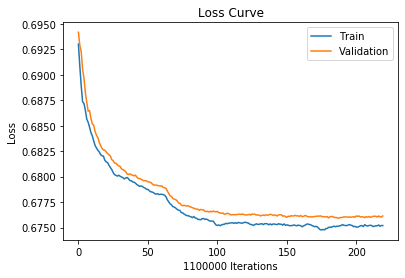

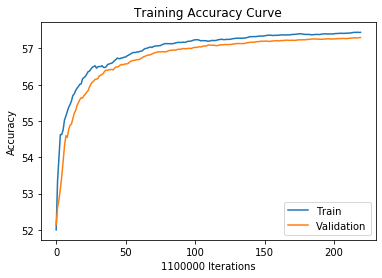

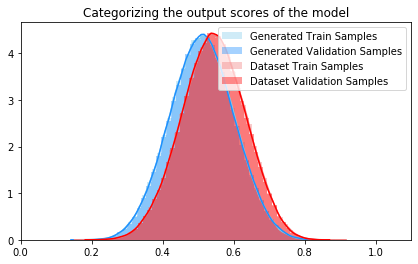

 95%|█████████▍| 353505/373243 [33:22<01:27, 225.63it/s]

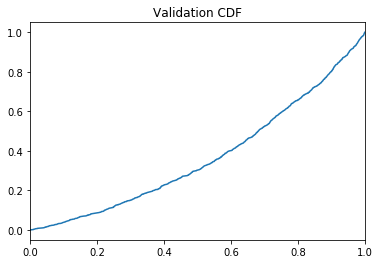

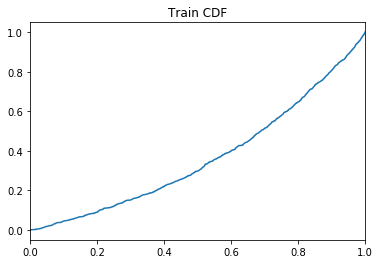

 95%|█████████▍| 353546/373243 [34:14<8:35:34,  1.57s/it] 

Training Accuracy at epoch 2: 57.44072727272727
Validation Accuracy epoch 2: 57.29754545454546
Training CDF at epoch 2: 0.36556863636363635
Validation CDF epoch 2: 0.36782990909090907
AUC epoch 2: 0.6027863636363636
Train: Sensitivity: 0.683266836182719 Specificity: 0.4527760026485783
Val: Sensitivity: 0.6819451830321339 Specificity: 0.4526216909605374


  0%|          | 27/373243 [00:00<23:27, 265.12it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 3  with learning rate:  [0.01]


  8%|▊         | 30237/373243 [01:41<19:39, 290.84it/s]

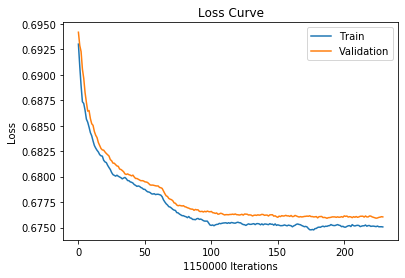

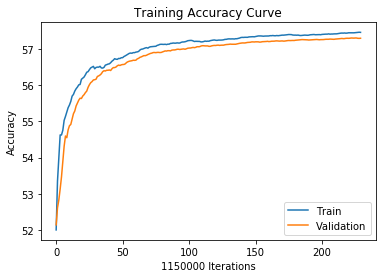

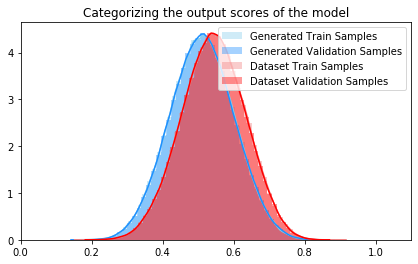

 22%|██▏       | 80250/373243 [06:24<20:52, 233.96it/s]

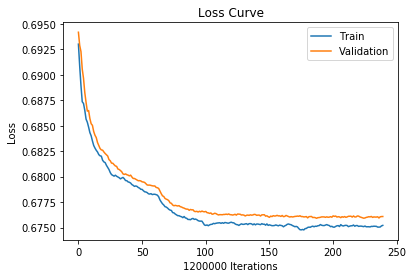

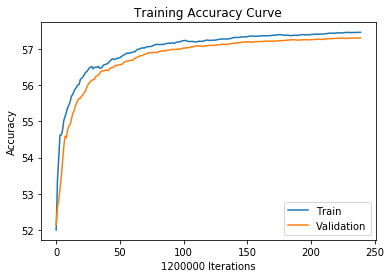

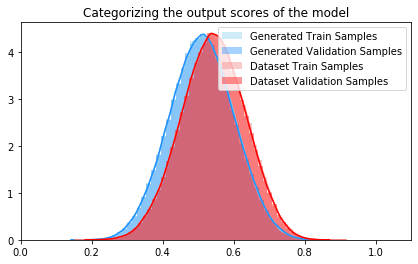

 22%|██▏       | 80250/373243 [06:40<20:52, 233.96it/s]

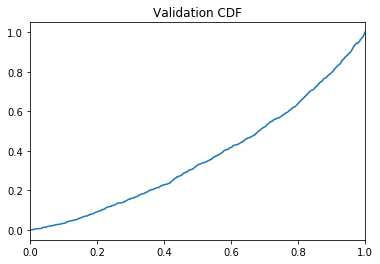

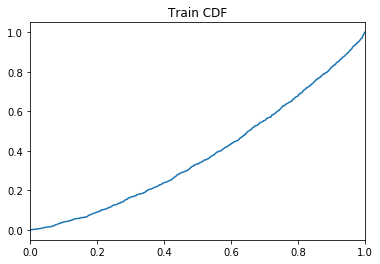

 22%|██▏       | 80298/373243 [07:34<56:57:52,  1.43it/s]

Training Accuracy at epoch 3: 57.46541666666667
Validation Accuracy epoch 3: 57.31283333333333
Training CDF at epoch 3: 0.38336054545454545
Validation CDF epoch 3: 0.36946236363636364
AUC epoch 3: 0.6030858333333333
Train: Sensitivity: 0.6824783395611372 Specificity: 0.4542057591678458
Val: Sensitivity: 0.6811565668193619 Specificity: 0.4538104716724687


 35%|███▍      | 129866/373243 [11:08<16:28, 246.22it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▏         | 7015/373243 [00:50<26:49, 227.60it/s]s]

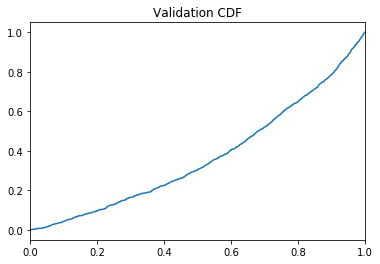

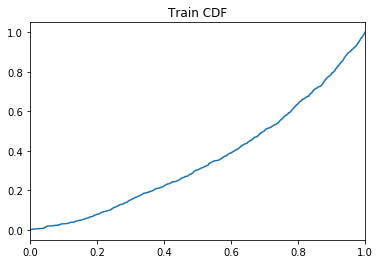

  2%|▏         | 7055/373243 [01:40<114:40:31,  1.13s/it]

Training Accuracy at epoch 4: 57.502
Validation Accuracy epoch 4: 57.35873333333333
Training CDF at epoch 4: 0.35811363636363636
Validation CDF epoch 4: 0.36833499999999997
AUC epoch 4: 0.603662
Train: Sensitivity: 0.6815386636551284 Specificity: 0.45598395207078707
Val: Sensitivity: 0.6801219947487891 Specificity: 0.4559181090784606


  6%|▌         | 22622/373243 [02:48<27:35, 211.77it/s]  

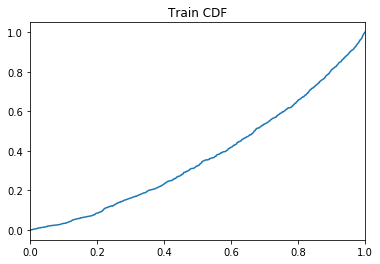

 10%|█         | 37327/373243 [03:46<58:24:47,  1.60it/s]

Training Accuracy at epoch 7: 57.588490566037734
Validation Accuracy epoch 7: 57.441962264150945
Training CDF at epoch 7: 0.37338899999999997
Validation CDF epoch 7: 0.382518
AUC epoch 7: 0.6047037735849057
Train: Sensitivity: 0.6790917230174258 Specificity: 0.4605757676475852
Val: Sensitivity: 0.6774626308755134 Specificity: 0.4605866669208207


 23%|██▎       | 87297/373243 [07:09<18:42, 254.84it/s]  

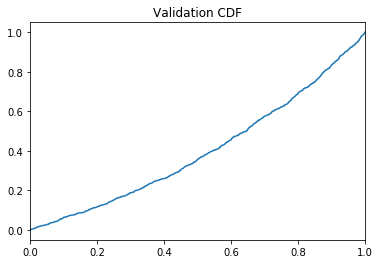

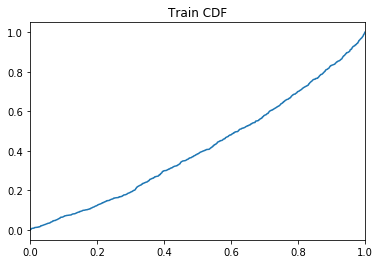

 18%|█▊        | 67597/373243 [07:46<201:12:09,  2.37s/it]

Training Accuracy at epoch 10: 57.620657894736844
Validation Accuracy epoch 10: 57.48152631578947
Training CDF at epoch 10: 0.4132228181818182
Validation CDF epoch 10: 0.40113954545454544
AUC epoch 10: 0.6051371052631579
Train: Sensitivity: 0.6782796327361872 Specificity: 0.4621537830615306
Val: Sensitivity: 0.6766120136381869 Specificity: 0.4623742800177226


 31%|███▏      | 117554/373243 [11:20<19:15, 221.23it/s]  

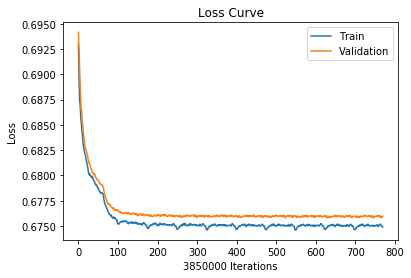

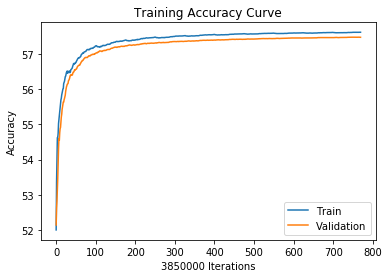

 31%|███▏      | 117554/373243 [11:40<19:15, 221.23it/s]

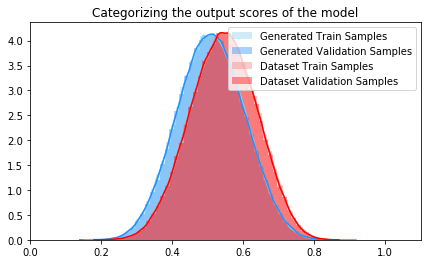

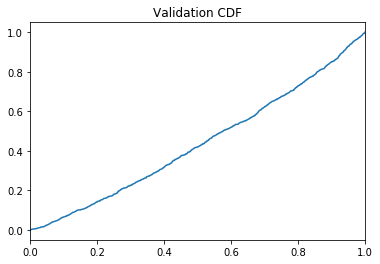

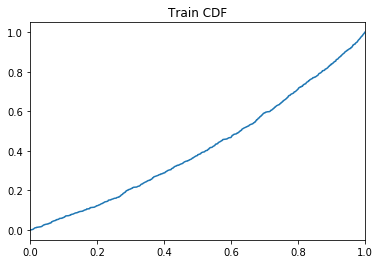

 32%|███▏      | 117597/373243 [12:48<82:36:26,  1.16s/it] 

Training Accuracy at epoch 10: 57.62207792207792
Validation Accuracy epoch 10: 57.478779220779224
Training CDF at epoch 10: 0.4154705454545454
Validation CDF epoch 10: 0.43764545454545456
AUC epoch 10: 0.6051272727272727
Train: Sensitivity: 0.6783215234394033 Specificity: 0.4621288077574387
Val: Sensitivity: 0.6766563613967591 Specificity: 0.46226667271617095


 39%|███▉      | 147207/373243 [14:57<17:08, 219.68it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 367538/373243 [35:46<00:19, 300.07it/s]

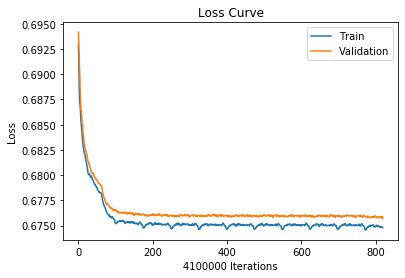

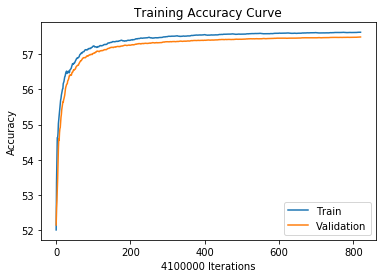

 98%|█████████▊| 367538/373243 [36:01<00:19, 300.07it/s]

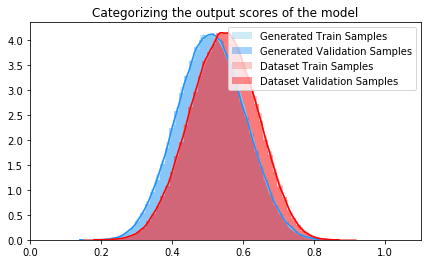

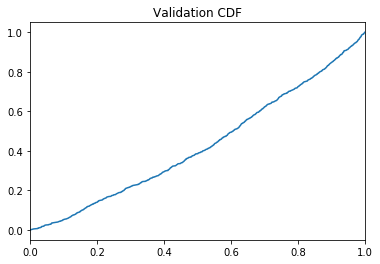

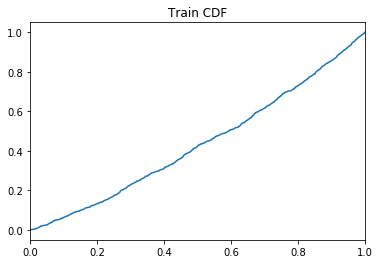

 98%|█████████▊| 367602/373243 [37:10<52:06,  1.80it/s]  

Training Accuracy at epoch 10: 57.627682926829266
Validation Accuracy epoch 10: 57.49258536585366
Training CDF at epoch 10: 0.43641963636363634
Validation CDF epoch 10: 0.42628981818181816
AUC epoch 10: 0.6052226829268292
Train: Sensitivity: 0.6782592178182267 Specificity: 0.4623156842259112
Val: Sensitivity: 0.6765977834948064 Specificity: 0.46262237288414


  0%|          | 39/373243 [00:00<16:05, 386.67it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 11  with learning rate:  [0.009000000000000001]


 11%|█         | 41859/373243 [02:12<18:55, 291.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 46%|████▌     | 171062/373243 [16:14<14:07, 238.64it/s]

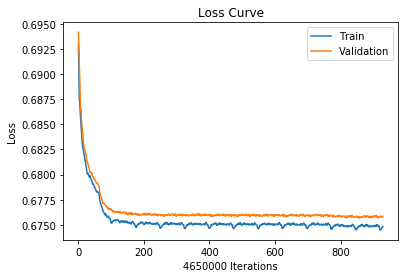

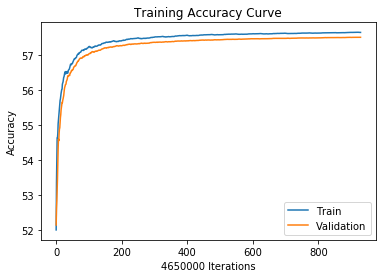

 46%|████▌     | 171062/373243 [16:30<14:07, 238.64it/s]

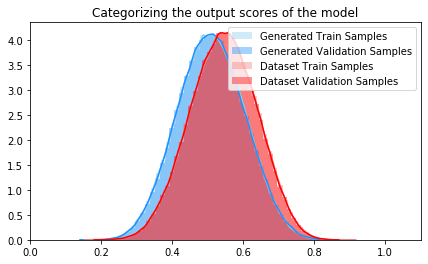

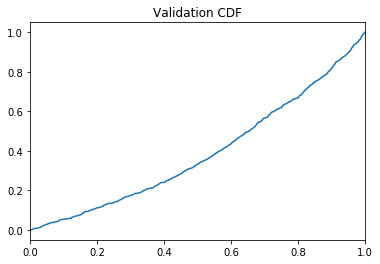

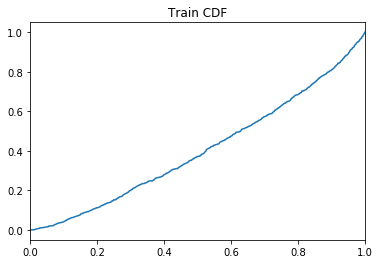

 46%|████▌     | 171110/373243 [17:47<50:16:43,  1.12it/s]

Training Accuracy at epoch 12: 57.63972043010752
Validation Accuracy epoch 12: 57.50034408602151
Training CDF at epoch 12: 0.4033947272727273
Validation CDF epoch 12: 0.3893095454545455
AUC epoch 12: 0.6053877419354838
Train: Sensitivity: 0.6780917040283821 Specificity: 0.4627610695872885
Val: Sensitivity: 0.676345829034291 Specificity: 0.4630691358449338


 99%|█████████▉| 371066/373243 [37:02<00:08, 243.51it/s]  

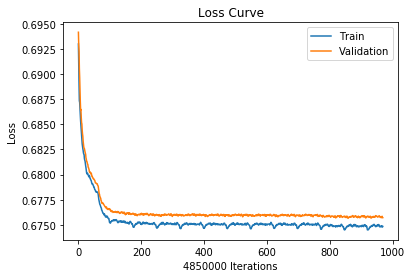

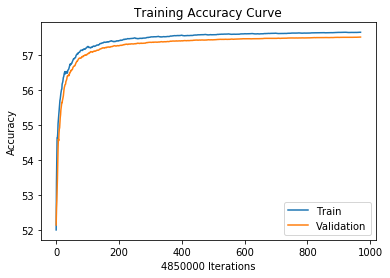

 99%|█████████▉| 371066/373243 [37:20<00:08, 243.51it/s]

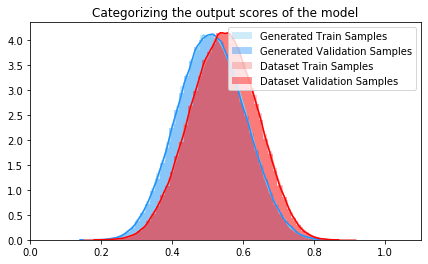

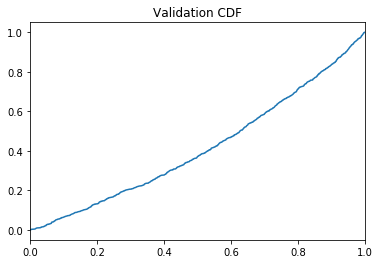

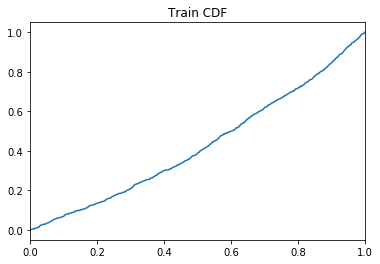

 99%|█████████▉| 371111/373243 [38:40<41:00,  1.15s/it] 

Training Accuracy at epoch 12: 57.6440206185567
Validation Accuracy epoch 12: 57.50655670103093
Training CDF at epoch 12: 0.4280424545454546
Validation CDF epoch 12: 0.41500154545454543
AUC epoch 12: 0.6054558762886598
Train: Sensitivity: 0.6780702271895255 Specificity: 0.4628752498900898
Val: Sensitivity: 0.6763415025079512 Specificity: 0.46319802681367206


  0%|          | 26/373243 [00:00<24:38, 252.37it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 13  with learning rate:  [0.009000000000000001]


 13%|█▎        | 47838/373243 [03:23<18:53, 286.98it/s]

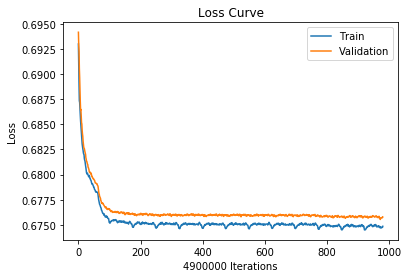

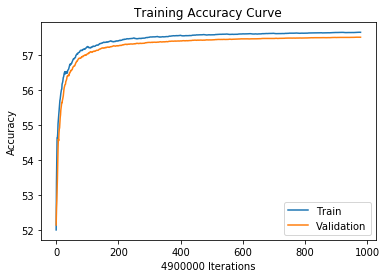

 13%|█▎        | 47838/373243 [03:40<18:53, 286.98it/s]

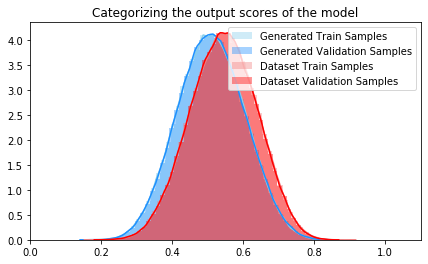

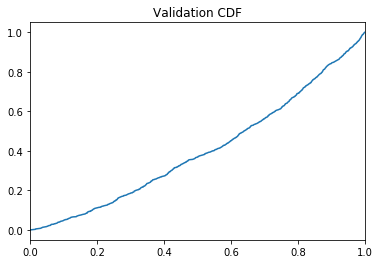

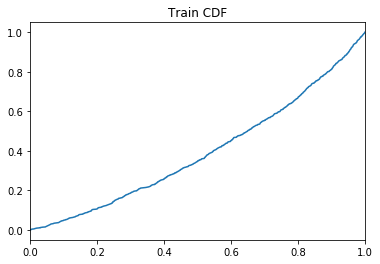

 13%|█▎        | 47873/373243 [04:58<597:57:05,  6.62s/it]

Training Accuracy at epoch 13: 57.645857142857146
Validation Accuracy epoch 13: 57.50495918367347
Training CDF at epoch 13: 0.3929912727272727
Validation CDF epoch 13: 0.40211936363636364
AUC epoch 13: 0.6055010204081632
Train: Sensitivity: 0.6779915338071493 Specificity: 0.46300815924044136
Val: Sensitivity: 0.6762320483837226 Specificity: 0.4632827740949547


 20%|██        | 76365/373243 [06:32<16:44, 295.68it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|███▉      | 147837/373243 [13:02<15:00, 250.36it/s]

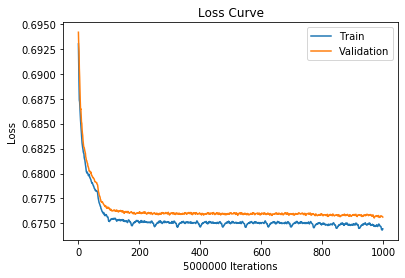

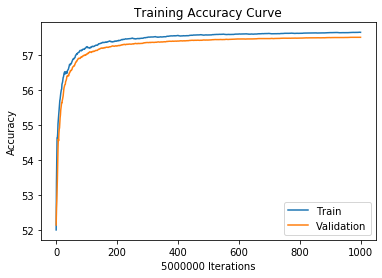

 40%|███▉      | 147837/373243 [13:20<15:00, 250.36it/s]

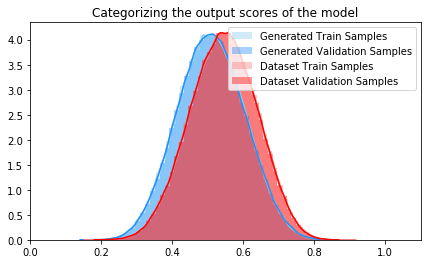

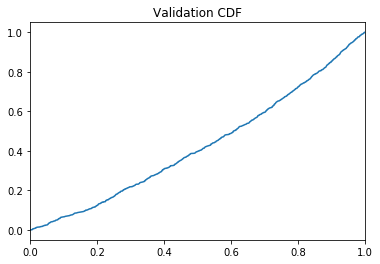

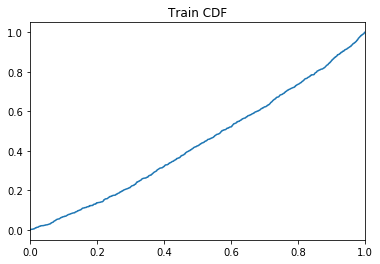

 40%|███▉      | 147867/373243 [14:37<312:42:53,  5.00s/it]

Training Accuracy at epoch 13: 57.64896
Validation Accuracy epoch 13: 57.50652
Training CDF at epoch 13: 0.4401314545454545
Validation CDF epoch 13: 0.42677472727272725
AUC epoch 13: 0.6055422
Train: Sensitivity: 0.678069054798845 Specificity: 0.4629780126565178
Val: Sensitivity: 0.6762902586614233 Specificity: 0.463249457006718


 53%|█████▎    | 197816/373243 [18:13<12:05, 241.83it/s]   

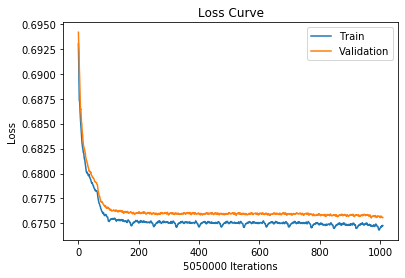

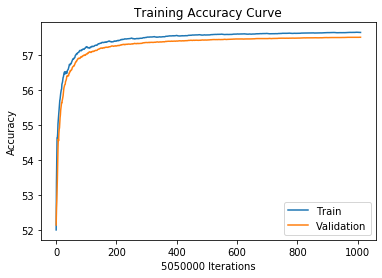

 53%|█████▎    | 197816/373243 [18:30<12:05, 241.83it/s]

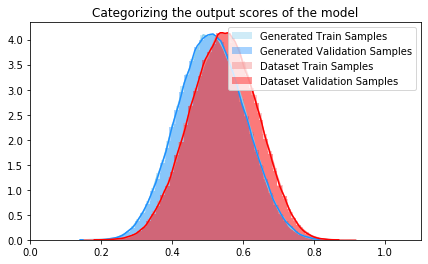

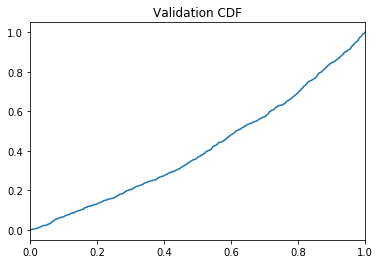

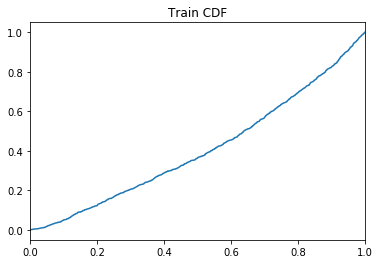

 53%|█████▎    | 197867/373243 [19:49<39:16:03,  1.24it/s]

Training Accuracy at epoch 13: 57.64570297029703
Validation Accuracy epoch 13: 57.50784158415841
Training CDF at epoch 13: 0.40715718181818183
Validation CDF epoch 13: 0.412976
AUC epoch 13: 0.6055372277227723
Train: Sensitivity: 0.6780055391683593 Specificity: 0.46298478938388976
Val: Sensitivity: 0.6762859004557392 Specificity: 0.46329129960605625


 60%|█████▉    | 222699/373243 [21:36<10:51, 231.21it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 24593/373243 [01:45<26:40, 217.79it/s]

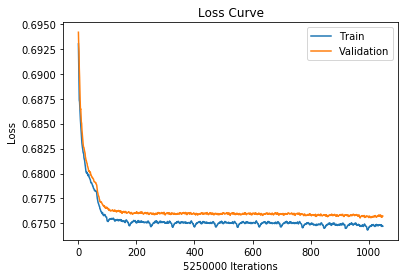

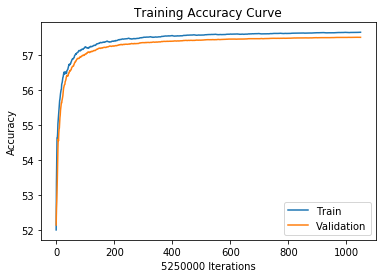

  7%|▋         | 24593/373243 [02:00<26:40, 217.79it/s]

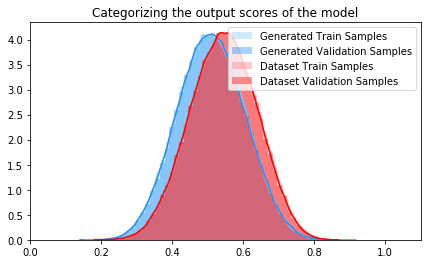

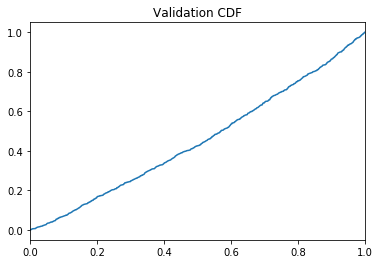

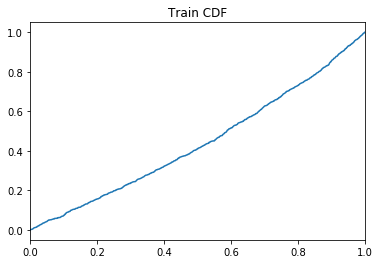

  7%|▋         | 24625/373243 [03:22<393:45:33,  4.07s/it]

Training Accuracy at epoch 14: 57.65443809523809
Validation Accuracy epoch 14: 57.50921904761905
Training CDF at epoch 14: 0.44183900000000004
Validation CDF epoch 14: 0.4535419090909091
AUC epoch 14: 0.6056344761904762
Train: Sensitivity: 0.6780138859211947 Specificity: 0.46315958867866086
Val: Sensitivity: 0.676183103769521 Specificity: 0.4634289775699653


 20%|█▉        | 74571/373243 [06:28<17:23, 286.23it/s]   

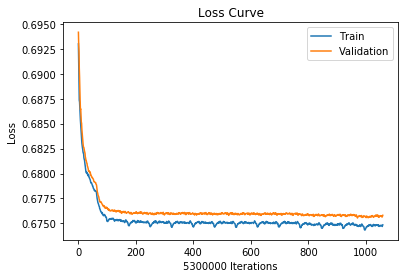

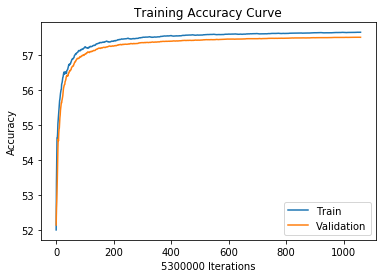

 20%|█▉        | 74571/373243 [06:40<17:23, 286.23it/s]

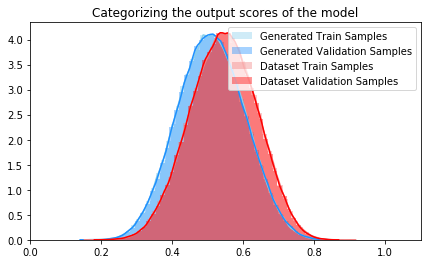

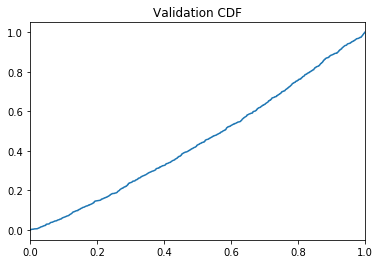

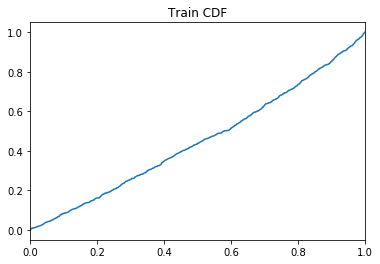

 20%|█▉        | 74630/373243 [08:05<62:56:03,  1.32it/s]

Training Accuracy at epoch 14: 57.65435849056604
Validation Accuracy epoch 14: 57.510301886792455
Training CDF at epoch 14: 0.4509769090909091
Validation CDF epoch 14: 0.44927945454545454
AUC epoch 14: 0.6056520754716981
Train: Sensitivity: 0.6779040947582347 Specificity: 0.4632907417675926
Val: Sensitivity: 0.6760914221291998 Specificity: 0.46355635466657985


 28%|██▊       | 106314/373243 [10:05<20:21, 218.46it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▎  | 274570/373243 [26:26<07:21, 223.63it/s]

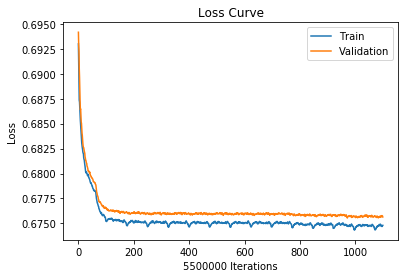

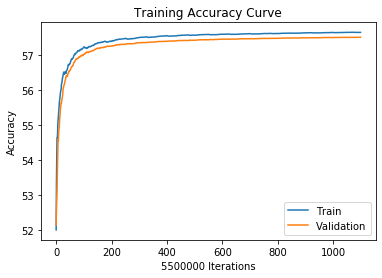

 74%|███████▎  | 274570/373243 [26:40<07:21, 223.63it/s]

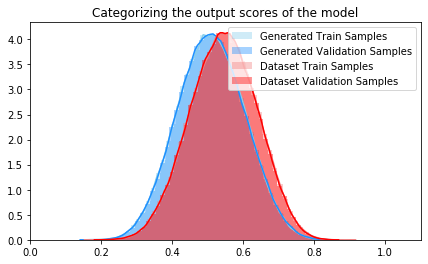

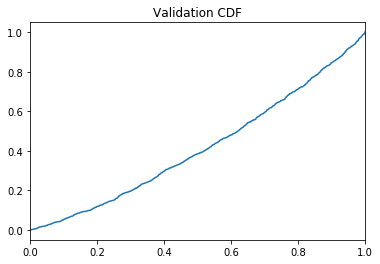

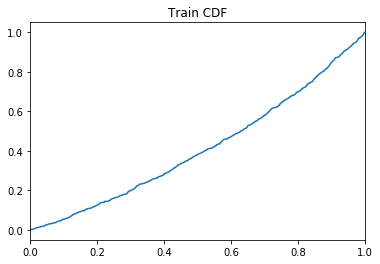

 74%|███████▎  | 274624/373243 [27:59<19:17:35,  1.42it/s]

Training Accuracy at epoch 14: 57.653290909090906
Validation Accuracy epoch 14: 57.513090909090906
Training CDF at epoch 14: 0.4130128181818182
Validation CDF epoch 14: 0.41686945454545454
AUC epoch 14: 0.6056383636363636
Train: Sensitivity: 0.6779575412219474 Specificity: 0.4631923216114452
Val: Sensitivity: 0.6762192986376198 Specificity: 0.46347175151079395


 87%|████████▋ | 324582/373243 [31:27<03:24, 238.29it/s]  

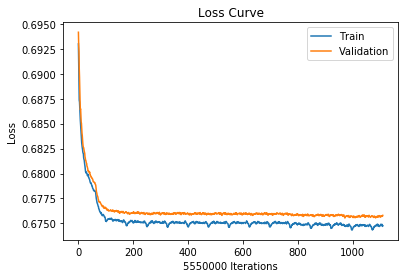

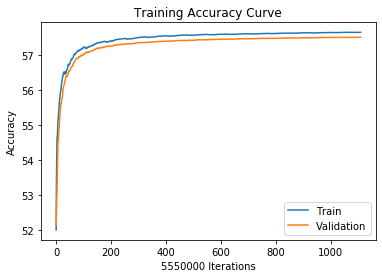

 87%|████████▋ | 324582/373243 [31:40<03:24, 238.29it/s]

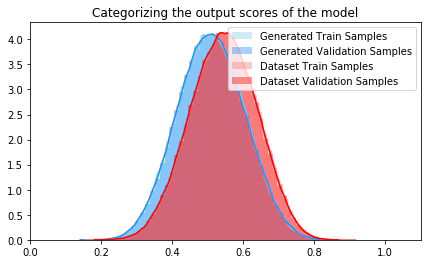

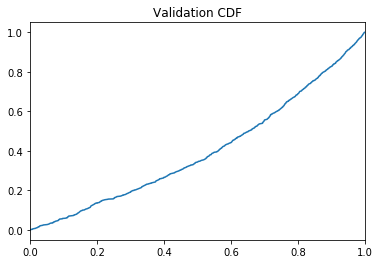

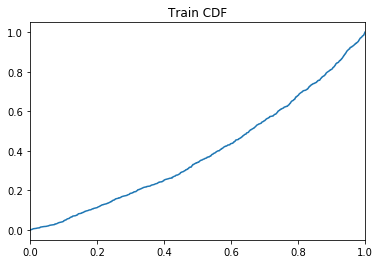

 87%|████████▋ | 324614/373243 [33:02<16:46:17,  1.24s/it]

Training Accuracy at epoch 14: 57.65587387387387
Validation Accuracy epoch 14: 57.514846846846844
Training CDF at epoch 14: 0.39063990909090907
Validation CDF epoch 14: 0.40004063636363635
AUC epoch 14: 0.6056133333333333
Train: Sensitivity: 0.6778804541737585 Specificity: 0.46334397109682146
Val: Sensitivity: 0.6761203944488787 Specificity: 0.4636144212811543


 95%|█████████▍| 353267/373243 [35:02<01:22, 243.30it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▍    | 201338/373243 [20:26<11:55, 240.39it/s]

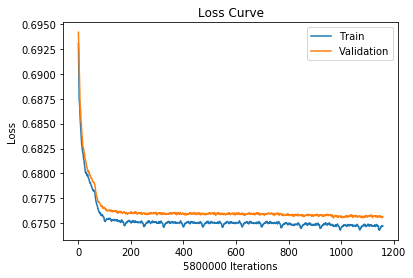

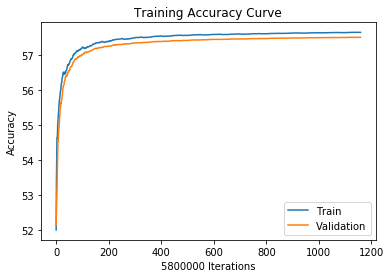

 54%|█████▍    | 201338/373243 [20:40<11:55, 240.39it/s]

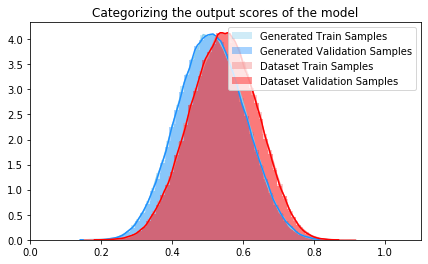

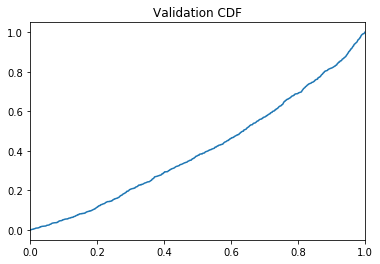

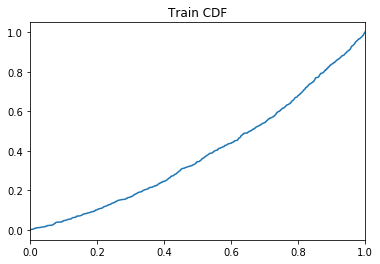

 54%|█████▍    | 201382/373243 [22:07<59:36:58,  1.25s/it]

Training Accuracy at epoch 15: 57.65844827586207
Validation Accuracy epoch 15: 57.51741379310345
Training CDF at epoch 15: 0.39050390909090904
Validation CDF epoch 15: 0.40628163636363634
AUC epoch 15: 0.6056505172413793
Train: Sensitivity: 0.6778722695225462 Specificity: 0.4634032812739579
Val: Sensitivity: 0.6761060266548227 Specificity: 0.46369285911001307


 65%|██████▍   | 242366/373243 [25:04<09:18, 234.48it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 61%|██████    | 228093/373243 [22:30<10:19, 234.47it/s]

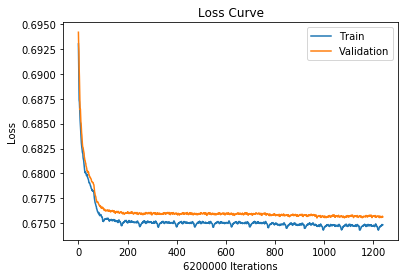

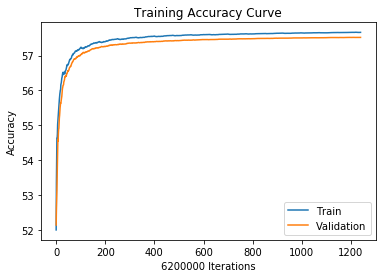

 61%|██████    | 228093/373243 [22:40<10:19, 234.47it/s]

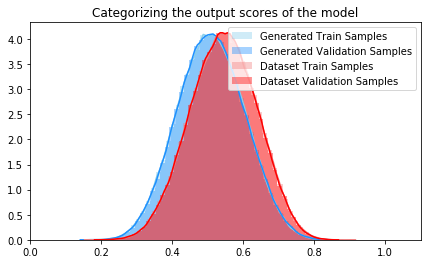

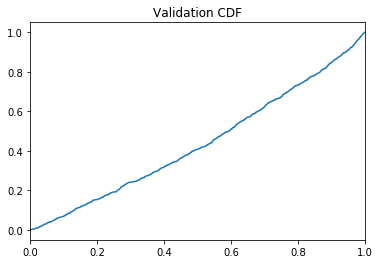

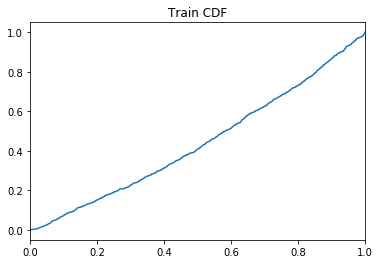

 61%|██████    | 228139/373243 [24:15<46:48:07,  1.16s/it]

Training Accuracy at epoch 16: 57.66595161290323
Validation Accuracy epoch 16: 57.52124193548387
Training CDF at epoch 16: 0.4410295454545455
Validation CDF epoch 16: 0.43893318181818186
AUC epoch 16: 0.605726935483871
Train: Sensitivity: 0.6778471963710804 Specificity: 0.46358820270882245
Val: Sensitivity: 0.6760321648919351 Specificity: 0.4638444098275124


 75%|███████▍  | 278107/373243 [27:50<07:07, 222.77it/s]  

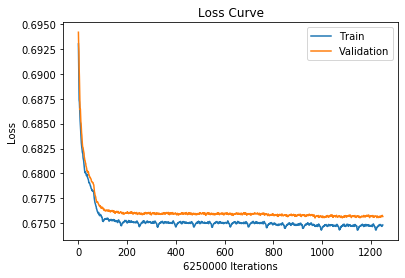

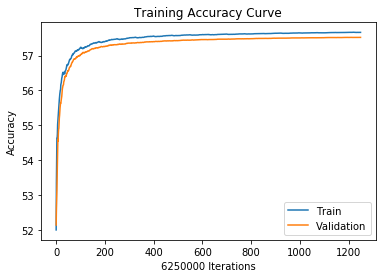

 75%|███████▍  | 278107/373243 [28:00<07:07, 222.77it/s]

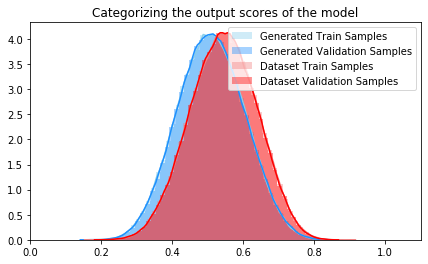

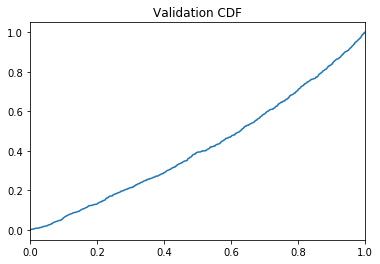

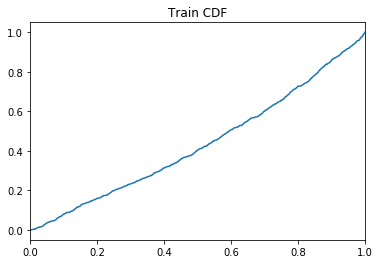

 75%|███████▍  | 278140/373243 [29:34<115:10:45,  4.36s/it]

Training Accuracy at epoch 16: 57.665392
Validation Accuracy epoch 16: 57.521568
Training CDF at epoch 16: 0.43442372727272727
Validation CDF epoch 16: 0.41813500000000003
AUC epoch 16: 0.60574
Train: Sensitivity: 0.6778359954740979 Specificity: 0.46358717084534357
Val: Sensitivity: 0.6760513187116364 Specificity: 0.4638347450849661


 88%|████████▊ | 328108/373243 [33:09<03:09, 238.29it/s]   

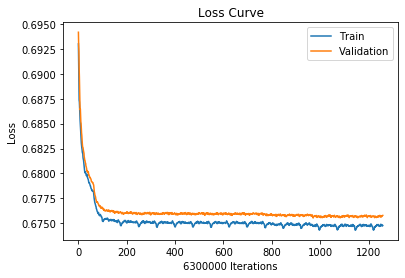

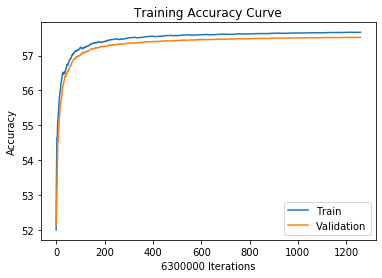

 88%|████████▊ | 328108/373243 [33:20<03:09, 238.29it/s]

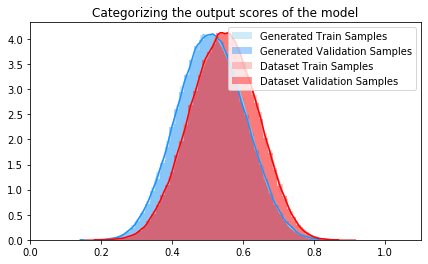

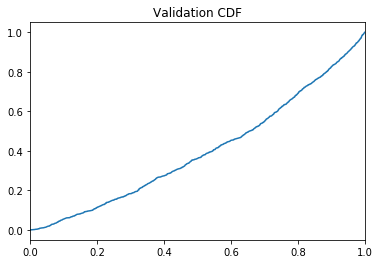

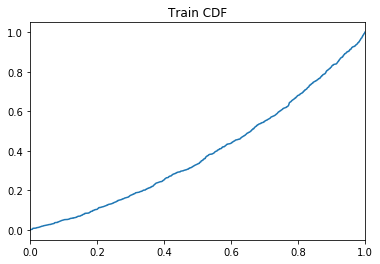

 88%|████████▊ | 328139/373243 [34:54<69:13:45,  5.53s/it]

Training Accuracy at epoch 16: 57.66825396825397
Validation Accuracy epoch 16: 57.52347619047619
Training CDF at epoch 16: 0.3891297272727273
Validation CDF epoch 16: 0.3984616363636364
AUC epoch 16: 0.605737619047619
Train: Sensitivity: 0.6777926264273277 Specificity: 0.4637018320240725
Val: Sensitivity: 0.6759712958656151 Specificity: 0.46396083700414037


  0%|          | 23/373243 [00:00<27:13, 228.46it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 17  with learning rate:  [0.009000000000000001]


  1%|▏         | 4867/373243 [00:20<25:38, 239.40it/s]

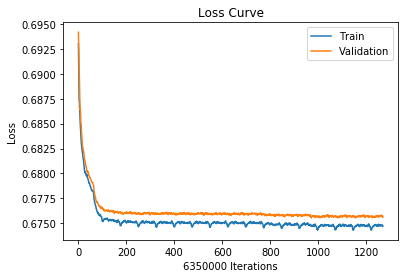

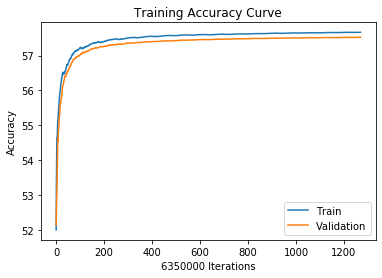

  1%|▏         | 4867/373243 [00:40<25:38, 239.40it/s]

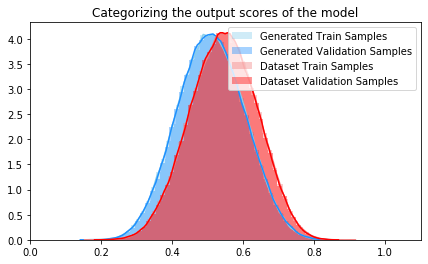

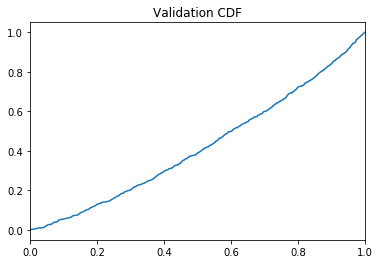

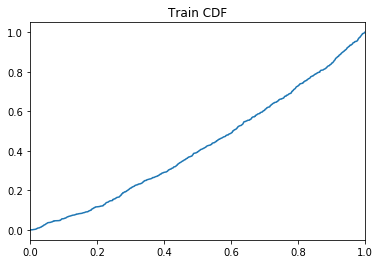

  1%|▏         | 4885/373243 [02:06<1137:30:33, 11.12s/it]

Training Accuracy at epoch 17: 57.66927559055118
Validation Accuracy epoch 17: 57.52444094488189
Training CDF at epoch 17: 0.42324436363636364
Validation CDF epoch 17: 0.4210371818181818
AUC epoch 17: 0.6057527559055118
Train: Sensitivity: 0.6778029804995391 Specificity: 0.4637114777800638
Val: Sensitivity: 0.6759720951166455 Specificity: 0.46398409147402436


  8%|▊         | 28978/373243 [03:50<25:31, 224.72it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 55%|█████▍    | 204865/373243 [21:03<12:08, 231.18it/s]

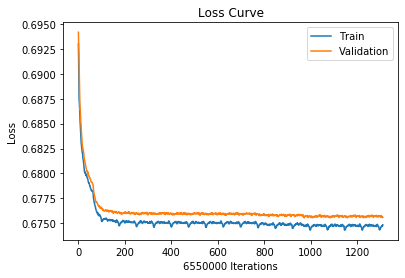

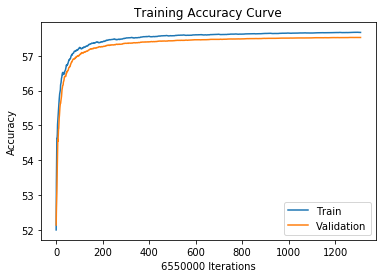

 55%|█████▍    | 204865/373243 [21:20<12:08, 231.18it/s]

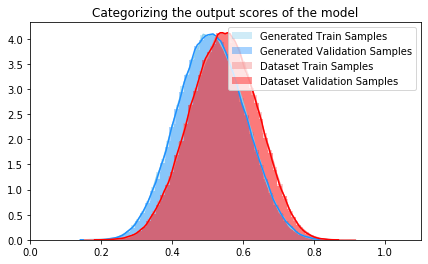

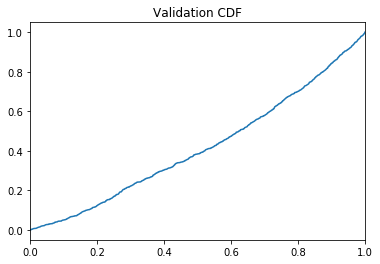

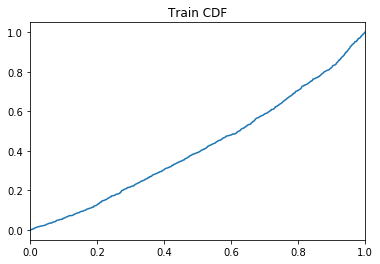

 55%|█████▍    | 204885/373243 [22:50<261:42:46,  5.60s/it]

Training Accuracy at epoch 17: 57.66928244274809
Validation Accuracy epoch 17: 57.52406106870229
Training CDF at epoch 17: 0.4193791818181818
Validation CDF epoch 17: 0.417217
AUC epoch 17: 0.6057514503816794
Train: Sensitivity: 0.6777734414665977 Specificity: 0.46374427369746113
Val: Sensitivity: 0.675936683505376 Specificity: 0.46401551785407896


 68%|██████▊   | 254855/373243 [26:26<08:28, 233.00it/s]   

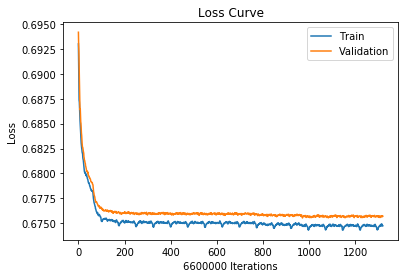

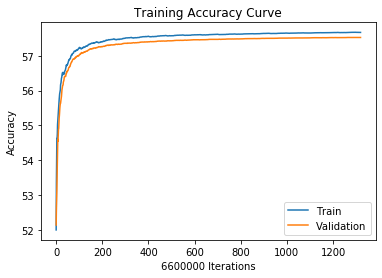

 68%|██████▊   | 254855/373243 [26:40<08:28, 233.00it/s]

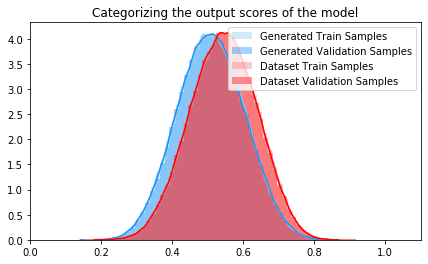

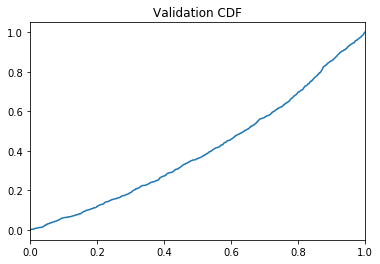

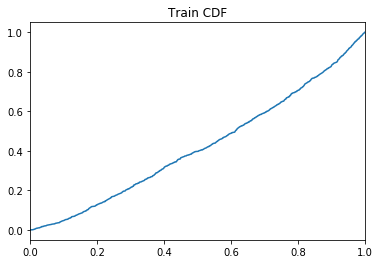

 68%|██████▊   | 254897/373243 [28:14<53:15:34,  1.62s/it]

Training Accuracy at epoch 17: 57.66939393939394
Validation Accuracy epoch 17: 57.52430303030303
Training CDF at epoch 17: 0.4215082727272727
Validation CDF epoch 17: 0.40694436363636366
AUC epoch 17: 0.6057775757575757
Train: Sensitivity: 0.6777764507069427 Specificity: 0.4637404739340142
Val: Sensitivity: 0.6759427338820682 Specificity: 0.4640131223150784


 82%|████████▏ | 304860/373243 [31:52<05:19, 213.91it/s]  

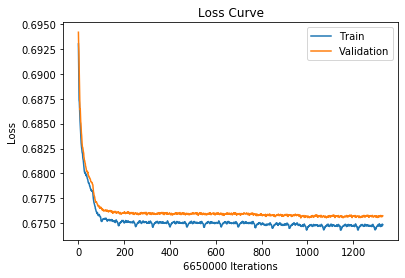

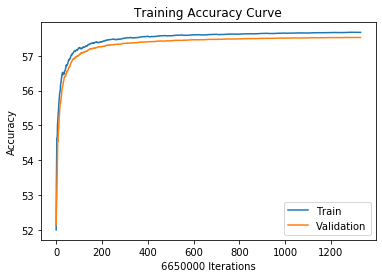

 82%|████████▏ | 304860/373243 [32:10<05:19, 213.91it/s]

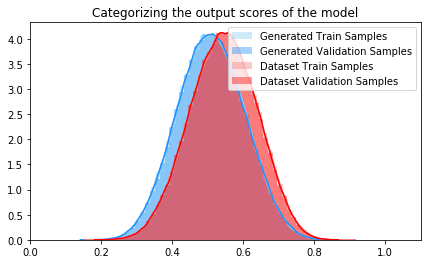

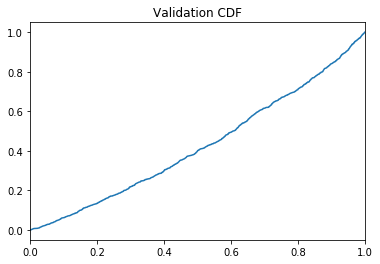

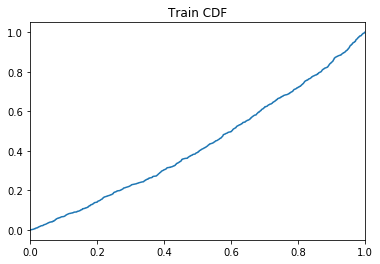

 82%|████████▏ | 304897/373243 [33:40<48:04:26,  2.53s/it]

Training Accuracy at epoch 17: 57.670646616541354
Validation Accuracy epoch 17: 57.52396992481203
Training CDF at epoch 17: 0.4308162727272727
Validation CDF epoch 17: 0.4265313636363636
AUC epoch 17: 0.6058042105263158
Train: Sensitivity: 0.6777480823257096 Specificity: 0.4638043908451411
Val: Sensitivity: 0.6758929768646017 Specificity: 0.4640593411406675


 87%|████████▋ | 323604/373243 [35:01<03:18, 249.94it/s]  

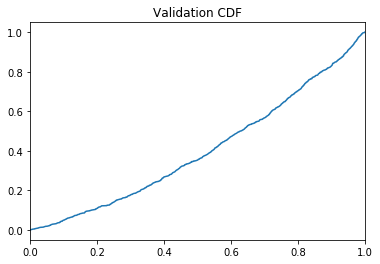

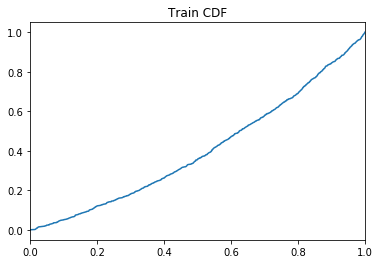

 42%|████▏     | 158409/373243 [18:09<129:40:31,  2.17s/it]

Training Accuracy at epoch 19: 57.68062068965517
Validation Accuracy epoch 19: 57.52990344827586
Training CDF at epoch 19: 0.40466590909090905
Validation CDF epoch 19: 0.40329436363636373
AUC epoch 19: 0.6058324137931035
Train: Sensitivity: 0.6777499161013307 Specificity: 0.4640082991720688
Val: Sensitivity: 0.6758183421757773 Specificity: 0.46426742621197675


 56%|█████▌    | 208367/373243 [21:44<12:20, 222.75it/s]   

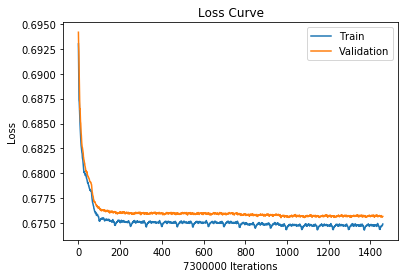

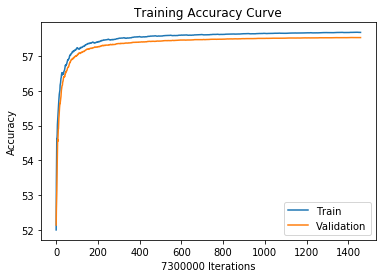

 56%|█████▌    | 208367/373243 [22:00<12:20, 222.75it/s]

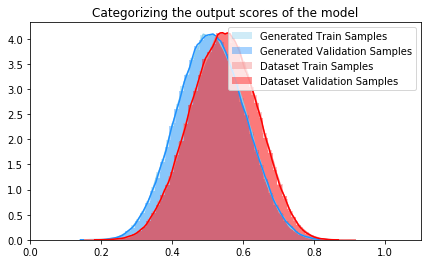

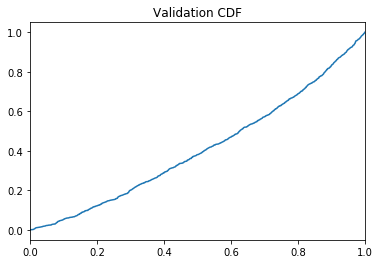

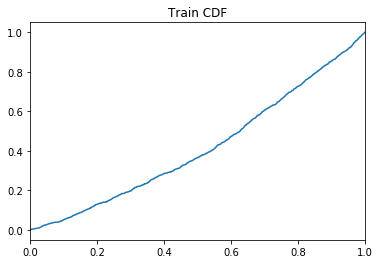

 56%|█████▌    | 208412/373243 [23:37<68:01:52,  1.49s/it]

Training Accuracy at epoch 19: 57.678383561643834
Validation Accuracy epoch 19: 57.52932876712329
Training CDF at epoch 19: 0.41681118181818183
Validation CDF epoch 19: 0.40984218181818177
AUC epoch 19: 0.6058230136986301
Train: Sensitivity: 0.6777282100375452 Specificity: 0.46398608416792747
Val: Sensitivity: 0.6758168290149923 Specificity: 0.46425720363867107


 64%|██████▍   | 238291/373243 [25:46<09:35, 234.69it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 92%|█████████▏| 342015/373243 [37:01<02:13, 233.64it/s]

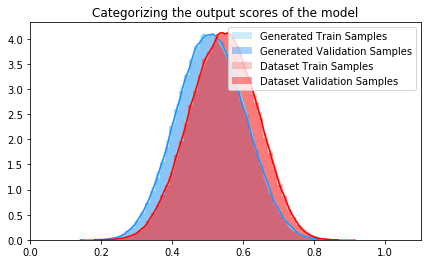

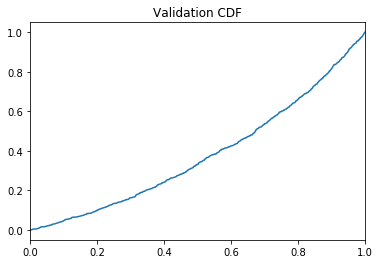

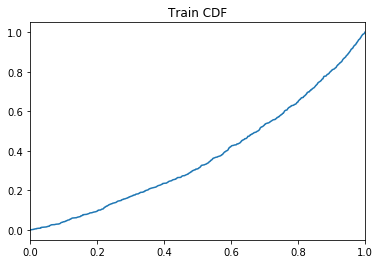

 96%|█████████▌| 358410/373243 [40:05<3:57:17,  1.04it/s]

Training Accuracy at epoch 19: 57.68311409395973
Validation Accuracy epoch 19: 57.53340939597315
Training CDF at epoch 19: 0.3736552727272727
Validation CDF epoch 19: 0.3802781818181818
AUC epoch 19: 0.605826577181208
Train: Sensitivity: 0.6777392776922738 Specificity: 0.4640728034022215
Val: Sensitivity: 0.675803979899991 Specificity: 0.46436025121244584


  0%|          | 24/373243 [00:00<26:17, 236.55it/s]

Saving to:  model_checkpoints/binary/ConvBaseline/09172020_2.pth
Starting epoch: 20  with learning rate:  [0.007290000000000001]


  9%|▉         | 35120/373243 [02:31<25:31, 220.71it/s]

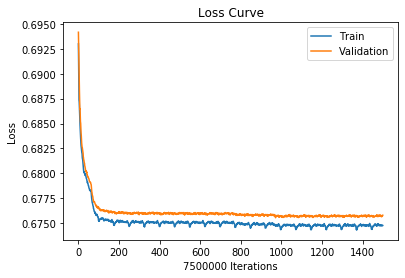

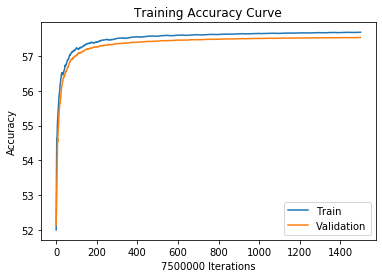

  9%|▉         | 35120/373243 [02:50<25:31, 220.71it/s]

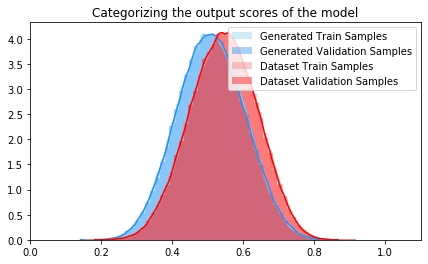

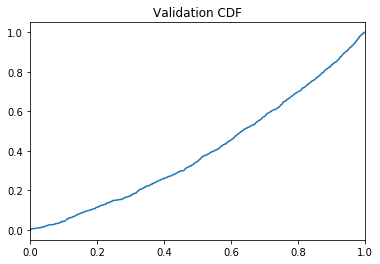

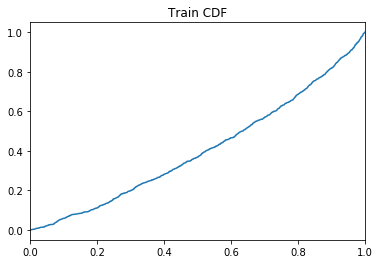

  9%|▉         | 35168/373243 [04:25<112:53:58,  1.20s/it]

Training Accuracy at epoch 20: 57.68421333333333
Validation Accuracy epoch 20: 57.533186666666666
Training CDF at epoch 20: 0.4049742727272727
Validation CDF epoch 20: 0.4001477272727273
AUC epoch 20: 0.6058386666666666
Train: Sensitivity: 0.6776848875572977 Specificity: 0.4641653882572282
Val: Sensitivity: 0.6757331773882311 Specificity: 0.4644255819722458


 17%|█▋        | 64302/373243 [06:33<24:15, 212.24it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 24%|██▎       | 88636/373243 [08:15<20:58, 226.18it/s]]

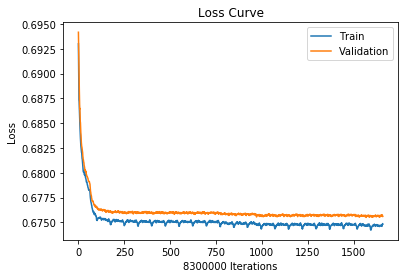

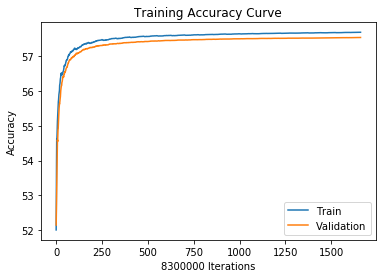

 24%|██▎       | 88636/373243 [08:30<20:58, 226.18it/s]

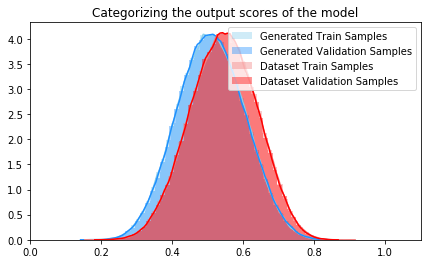

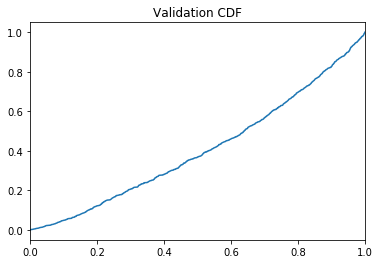

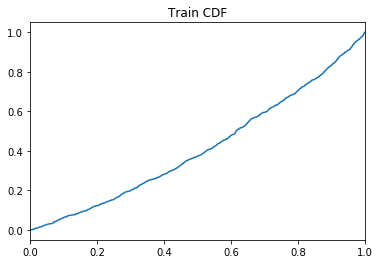

 24%|██▍       | 88686/373243 [10:21<117:04:31,  1.48s/it]

Training Accuracy at epoch 22: 57.694722891566265
Validation Accuracy epoch 22: 57.54449397590361
Training CDF at epoch 22: 0.41416736363636364
Validation CDF epoch 22: 0.4066593636363637
AUC epoch 22: 0.6059671084337349
Train: Sensitivity: 0.6777182984566147 Specificity: 0.46434842458570297
Val: Sensitivity: 0.6757623922747739 Specificity: 0.4646361940251201


 37%|███▋      | 138631/373243 [13:08<17:14, 226.74it/s]  

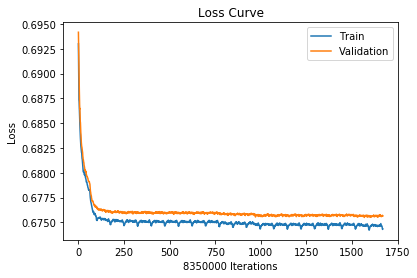

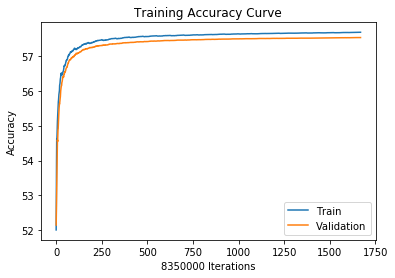

 37%|███▋      | 138631/373243 [13:20<17:14, 226.74it/s]

In [ ]:
model = ConvBaseline()
model_name = model.name
model_id = "09172020_2"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 200
BATCH_SIZE = 64
cdf=False
if cdf:
   # For the CDF functions, we need to generate a dataset of new examples
    S_new = GeneratedDataset(10*m) 
gamma = 1e-2
print("Using lambda val=", lambda_val)
print("Using encoding_style=", encoding_style)
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path, cdf=cdf)

## Evaluate the model

In [ ]:
def conv3x3(in_planes, out_planes, kernel_size=3, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                     padding=kernel_size//2, bias=True)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=1,
                               padding=kernel_size//2, bias=True)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class VariableLengthPooling(nn.Module):
    def forward(self, x, **kwargs):
        bounds = kwargs.get("bounds")
        # print("--------x--------", x.size(), x)
        # print("--------bounds--------", bounds.size(), bounds)
        cnt = torch.sum(bounds, dim=1)
        # print("--------cnt--------", cnt.size(), cnt)
        # print("--------bmm--------", torch.bmm(x, bounds).size(), torch.bmm(x, bounds))
        out = torch.bmm(x, bounds) / cnt
        # print("--------out--------", out.size(), out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "Resnet"
        self.single_alphabet=True
        self.inplanes = 192
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(48, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, x, bounds=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        x = self.conv_merge(x)
        x = torch.squeeze(x, dim=2)
        x = x.view(1, -1)
        
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

class ResNetSeparated(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "ResnetSeparated"
        self.single_alphabet=False
        self.inplanes = 192
        super(ResNetSeparated, self).__init__()
        self.conv1_apt = nn.Conv1d(4, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv1_pep = nn.Conv1d(20, 192, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        #self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        #self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        #self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(96, 1)
        
        self.apt_initial = nn.Sequential(self.conv1_apt, self.bn1, self.relu)
        self.pep_initial = nn.Sequential(self.conv1_pep, self.bn1, self.relu)
        
        

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        
        self.conv_layers = nn.Sequential(self.layer0, self.layer1, self.layer2,
                                         self.conv_merge)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, apt, pep, bounds=None):
        apt = self.apt_initial(apt)
        pep = self.pep_initial(pep)
        
        apt = self.conv_layers(apt)
        pep = self.conv_layers(pep)
        
        apt = torch.squeeze(apt, dim=2)
        pep = torch.squeeze(pep, dim=2)
        
        apt = apt.view(1, -1)
        pep = pep.view(1, -1)
        
        x = torch.cat((apt, pep), 1)
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

In [ ]:
# model = BlosumConvNet()
# model_name = model.name
# model.to(device)
# checkpointed_model = 'model_checkpoints/binary/%s/%s.pth' % (model_name, "09152020")
# checkpoint = torch.load(checkpointed_model)
# optimizer = SGD(model.parameters(), lr=1e-3)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# init_epoch = checkpoint['epoch'] +1
# print("Reloading model: ", model.name, " at epoch: ", init_epoch)
model.eval()

In [ ]:
# Calculate AUC
val_ds = [auc_ds_1, auc_ds_2, auc_ds_3]
for ds in val_ds:
    auc_tracker = 0
    for i in range(10000):
        idx = int(random.random()*len(ds))
        bio_sample, gen_sample = ds[idx]
        if model.single_alphabet:
            p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
            bio_score = model(p)
            p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
            gen_score = model(p)
        else:
            a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
            bio_score = model(a, p)
            a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
            gen_score = model(a, p)
        if bio_score > 0.5:
            auc_tracker += 1
        if gen_score < 0.5:
            auc_tracker += 1

    print("Test Accuracy: ", auc_tracker/20000.0)

In [ ]:
# Evaluate the decision threshold
thresholds = [i for i in range(48, 60)]
precisions = []
recalls = []
for i, t in enumerate(tqdm.tqdm(thresholds)):
    t = t*0.01
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(100):
        idx = int(random.random()*len(auc_ds_2))
        bio_sample, gen_sample = auc_ds_2[idx]
        if model.single_alphabet:
            p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
            bio_score = model(p)
            p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
            gen_score = model(p)
        else:
            a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
            bio_score = model(a, p)
            a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
            gen_score = model(a, p)
        if bio_score >= t:
            tp += 1
        elif bio_score < t:
            fn += 1    
        if gen_score < t:
            tn += 1
        elif gen_score >= t:
            fp += 1
    

    try:
        precision = tp/float(tp + fp)
    except:
        precision = tp/1
    try:
        recall = tp/float(tp + fn)
    except:
        recall = tp/1
    precisions.append(precision)
    recalls.append(recall)
plt.scatter(precisions, recalls)
plt.show()